In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import os
import glob
import pickle
import sys
import re
from collections import defaultdict
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import torch
sys.path.append("../benchmark/")

## Old Higgs Trajectories

In [9]:
folder = "../benchmark/logs/"
files_higgs = [
    "ho_higgs_coarse_10000.json",
    "ho_higgs_coarse_7500.json",
    "ho_higgs_coarse_5000.json",
]

In [5]:
data_higgs = []
for fn in files_higgs:
    with open(os.path.join(folder, fn), "r") as fh:
        data_higgs.append(json.load(fh))

In [6]:
def plot_hp(data):
    fig, ax = plt.subplots()
    num_iter = len(data['ho'])
    num_hos = len(data['ho'][0]['hparams'])
    time_range = [data['ho'][i]['time'] for i in range(num_iter)]
    
    for h in range(num_hos):
        ax.plot(time_range, [data['ho'][i]['hparams'][h] for i in range(num_iter)])
    ax.set_ylabel("Hyper-parameter values")
    ax.set_xlabel("Time (s)")

    ax2 = ax.twinx()
    ax2.plot(time_range, [data['ho'][i]['val_loss'] for i in range(num_iter)], lw=2, c="k",
             label="Validation loss")
    ax2.plot(time_range[1:], [data['partial_test_errors']['AUC'][i] for i in range(num_iter - 1)],
             lw=2, c='r', linestyle='--', label="Test AUC")
    
    ax2.scatter(time_range[-1], data_higgs[0][-1]['retrain_test_errors']['AUC'], s=90, label="Retrain test AUC")
    
    ax2.legend(loc="best")
    ax2.set_ylabel("Validation loss")
    

<IPython.core.display.Javascript object>


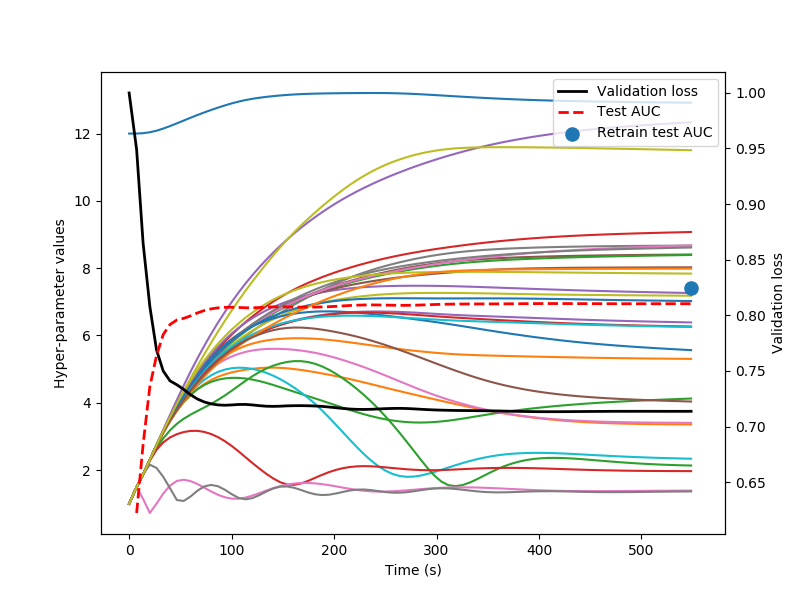

In [64]:
plot_hp(data_higgs[0][-1])

In [8]:
with open(os.path.join(folder, "hotraj_ho-higgs_1607960088133.csv"), "r") as fh:
    traj_data = json.load(fh)
# plot_hp(data_higgs[0][-1])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Grid search on Different Objectives

In [5]:
def gen_data_loc(e_name, dset):
    d = {}
    for model_name in ["gcv", "loocv", "sgpr", "hgrad-closed", "hgrad-ift", "creg-penfit", "creg-nopenfit"]:
        f = f"../benchmark/logs/{dset}_gs_{model_name}_{e_name}.pkl"
        if os.path.isfile(f):
            d[f"{dset}_{model_name}"] = f
    return d

In [6]:
data_loc = gen_data_loc("test_exp_m100", "boston")
data_loc.update(gen_data_loc("test_exp_m100", "energy"))
data_loc.update(gen_data_loc("test_exp_m100", "ho-higgs"))
data_loc.update(gen_data_loc("test_exp_m100", "protein"))
dict_loc = {}
for k, v in data_loc.items():
    with open(v, 'rb') as fh:
        dict_loc[k] = pickle.load(fh)

In [201]:
dict_loc['ho-higgs_sgpr']

[HPGridPoint(attributes={'Index': 0, 'sigma': 1.0, 'penalty': 1e-06}, results={'loss_log-det': tensor(-68939.3918, dtype=torch.float64), 'loss_data-fit': tensor(4.9900e+09, dtype=torch.float64), 'loss_trace': tensor(4.9900e+09), 'loss_const': tensor(9189.3853, dtype=torch.float64), 'loss': tensor(9.9799e+09, dtype=torch.float64), 'cum_time': 0.09200572967529297, 'train_c-error': 0.4704, 'test_c-error': 0.4692}),
 HPGridPoint(attributes={'Index': 1, 'sigma': 1.0, 'penalty': 3.72759372e-06}, results={'loss_log-det': tensor(-62373.7447, dtype=torch.float64), 'loss_data-fit': tensor(1.3387e+09, dtype=torch.float64), 'loss_trace': tensor(1.3387e+09), 'loss_const': tensor(9189.3853, dtype=torch.float64), 'loss': tensor(2.6773e+09, dtype=torch.float64), 'cum_time': 0.1089468002319336, 'train_c-error': 0.4704, 'test_c-error': 0.46915}),
 HPGridPoint(attributes={'Index': 2, 'sigma': 1.0, 'penalty': 1.38949549e-05}, results={'loss_log-det': tensor(-55808.0819, dtype=torch.float64), 'loss_data-fi

In [7]:
def get_clims(dict_loc, model_attr_list):
    cmin, cmax = 1e99, -1e99
    for i, (obj_name, attr) in enumerate(model_attr_list):
        cmin = min(cmin, min([el.results[attr] for el in dict_loc[obj_name]]))
        cmax = max(cmax, max([el.results[attr] for el in dict_loc[obj_name]]))
    return cmin, cmax
        
def do_plot(obj_name, dict_loc, ax, attr='loss', scale=None, **kwargs):
    log_set = {'sgpr', 'sgpr_new', 'loocv', 'loocv_new', 'hgrad-closed', 'gcv', 'creg-nopenfit'}
    do_log = False
    for log_el in log_set:
        if log_el in obj_name:
            do_log = True
    cdict = dict_loc[obj_name]
    sigmas = [el.attributes['sigma'] for el in cdict]
    penalties = [el.attributes['penalty'] for el in cdict]
    loss = np.asarray([el.results[attr] for el in cdict])
    if do_log:
        loss = np.log(loss)
    if scale == '01':
        min_, max_ = np.min(loss), np.max(loss)
        loss = (loss - min_) / (max_ - min_)
    elif scale == 'zscore':
        mean_, std_ = np.mean(loss), np.std(loss)
        loss = (loss - mean_) / std_
    ax.scatter(sigmas, penalties, c=loss, **kwargs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Penalty')
    if attr != 'loss':
        ax.set_title(attr)
    else:
        ax.set_title(obj_name)
        
def plot_all_models(dset, data_dict, err_name='NRMSE', cbar=False):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
    ax = ax.flatten()
    for i, (obj_name, attr) in enumerate([
                                  ('%s_sgpr' % dset, 'loss'),
                                  ('%s_loocv' % dset, 'loss'),
                                  ('%s_hgrad-closed' % dset, 'loss'),
                                  ('%s_gcv' % dset, 'loss'),
                                  ('%s_creg-nopenfit' % dset, 'loss'),
                                  ('%s_sgpr' % dset, 'test_%s' % err_name)]):
        do_plot(obj_name, data_dict, ax[i], attr=attr, scale=None, cmap='inferno')

    if cbar:
        # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.89, 0.15, 0.05, 0.7])
        fig.colorbar(ax[-1].collections[0], cax=cbar_ax)
        fig.tight_layout(rect=(0, 0, 0.87, 1))
    else:
        fig.tight_layout()

<IPython.core.display.Javascript object>


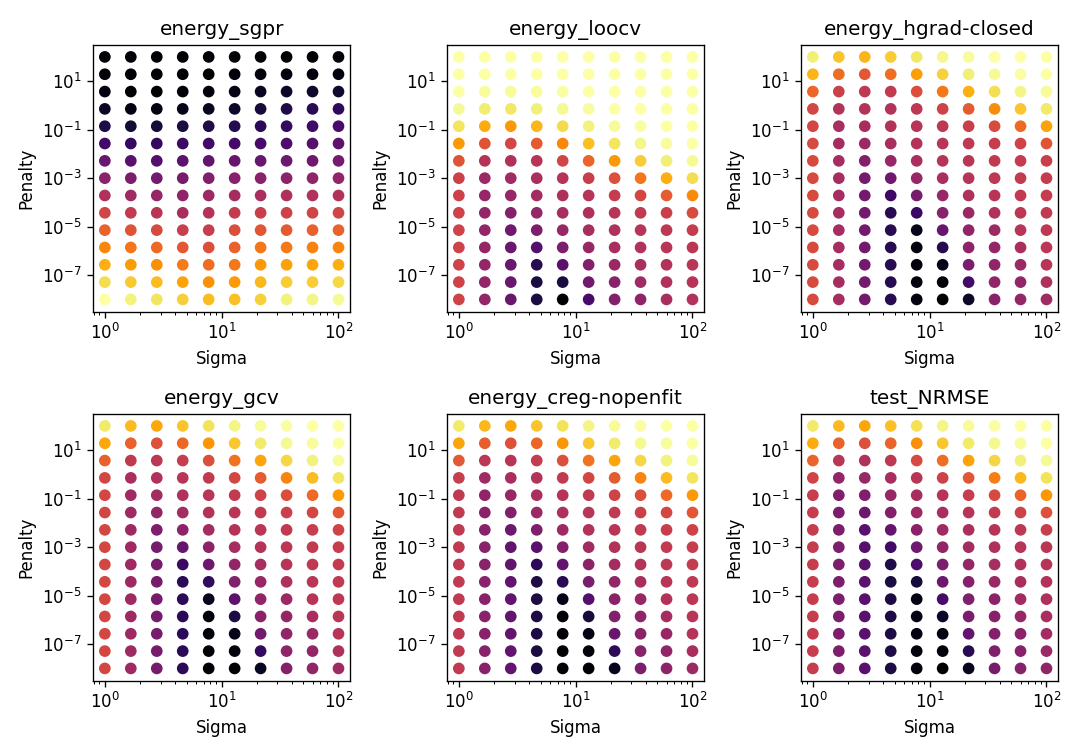

<IPython.core.display.Javascript object>


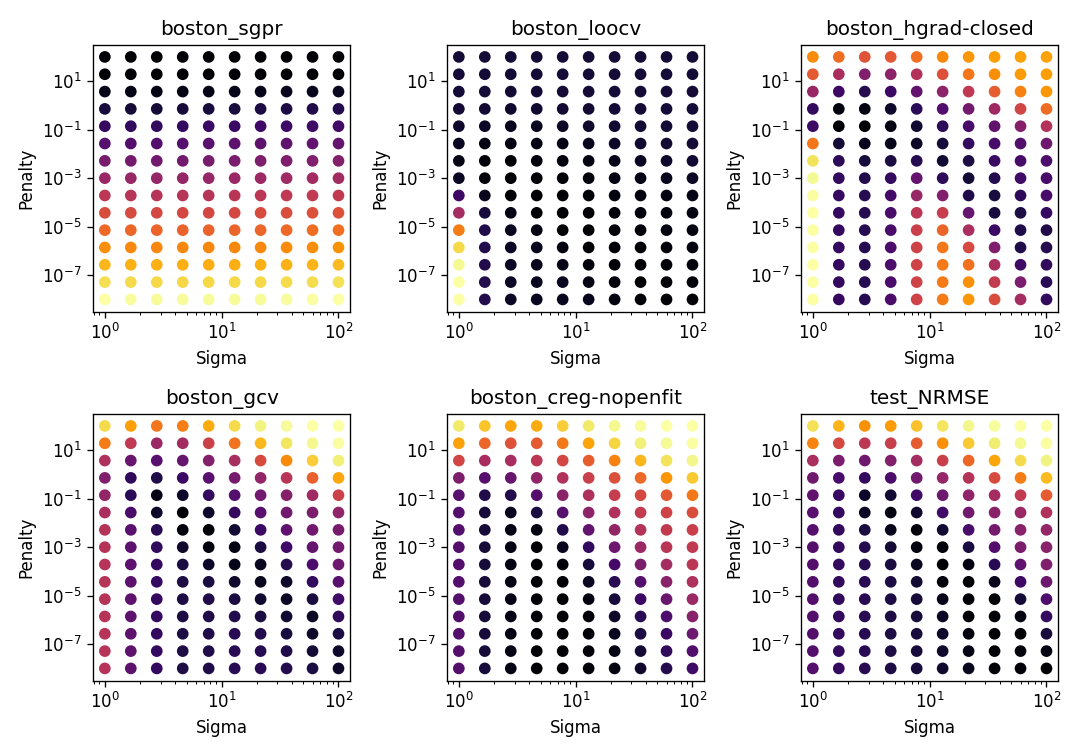

<IPython.core.display.Javascript object>


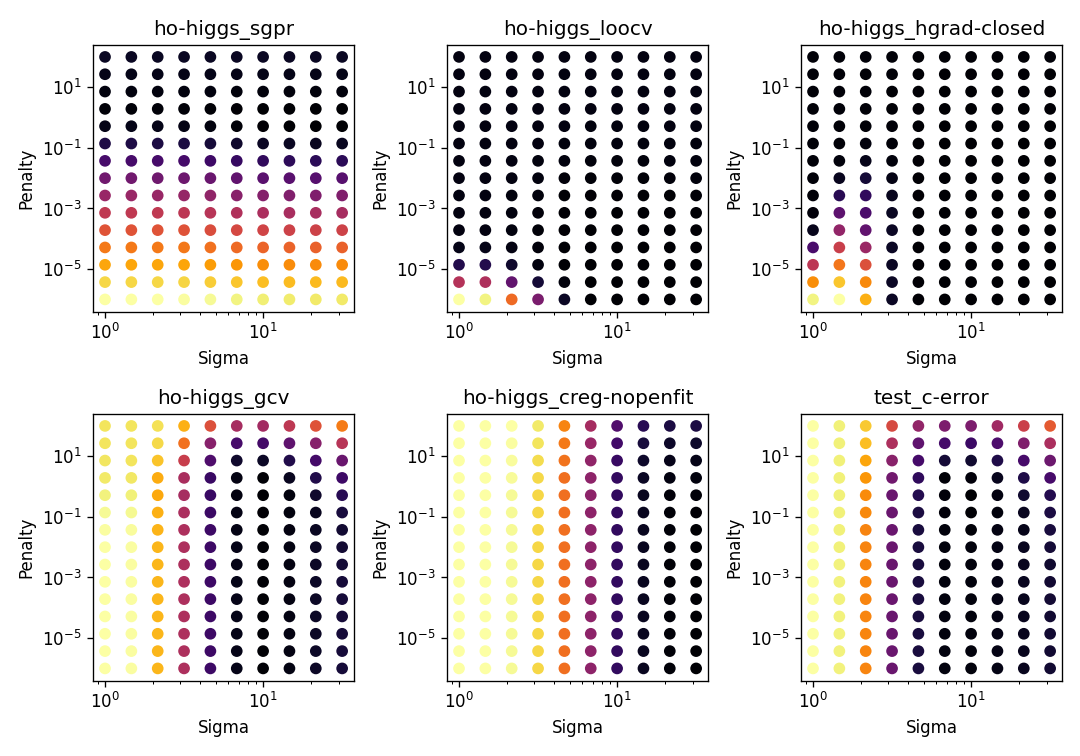

In [204]:
## test_exp_m100
plot_all_models('energy', dict_loc)
plot_all_models('boston', dict_loc)
plot_all_models('protein', dict_loc)
plot_all_models('ho-higgs', dict_loc, err_name='c-error')

<IPython.core.display.Javascript object>


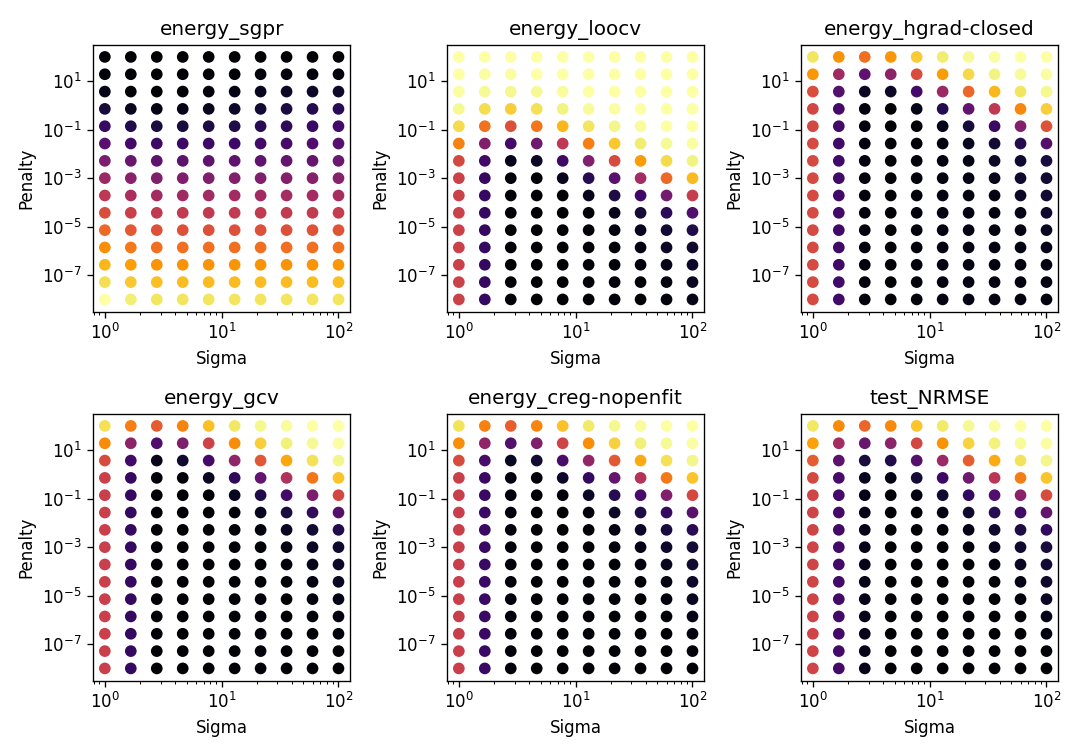

<IPython.core.display.Javascript object>


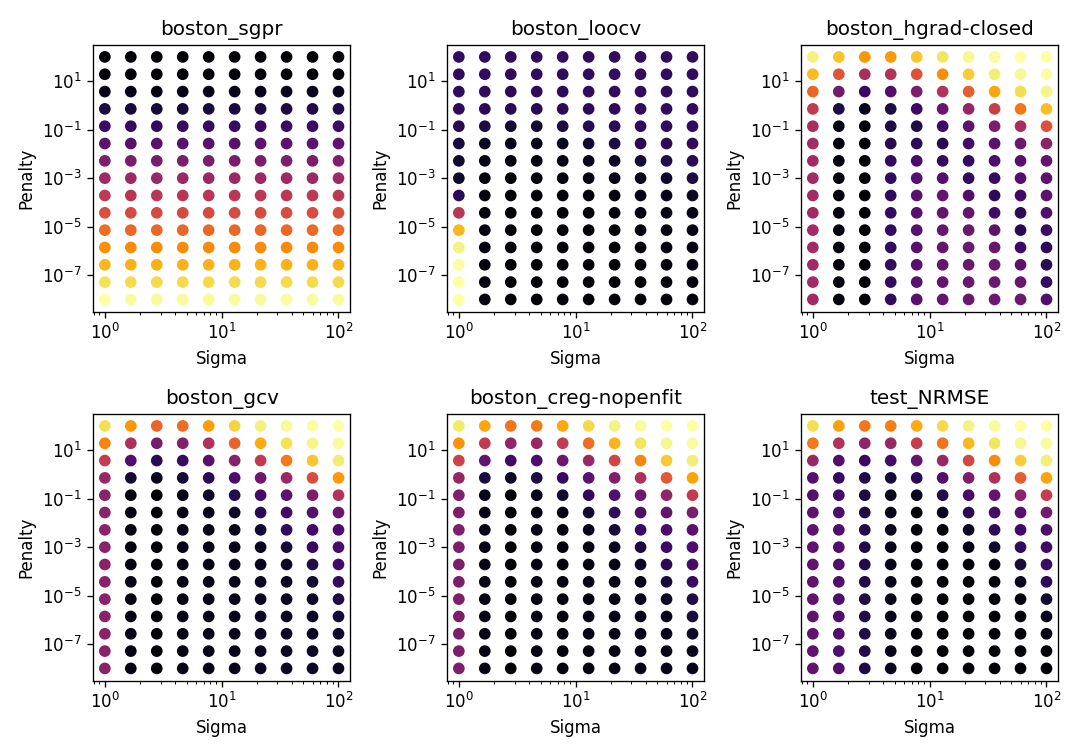

<IPython.core.display.Javascript object>


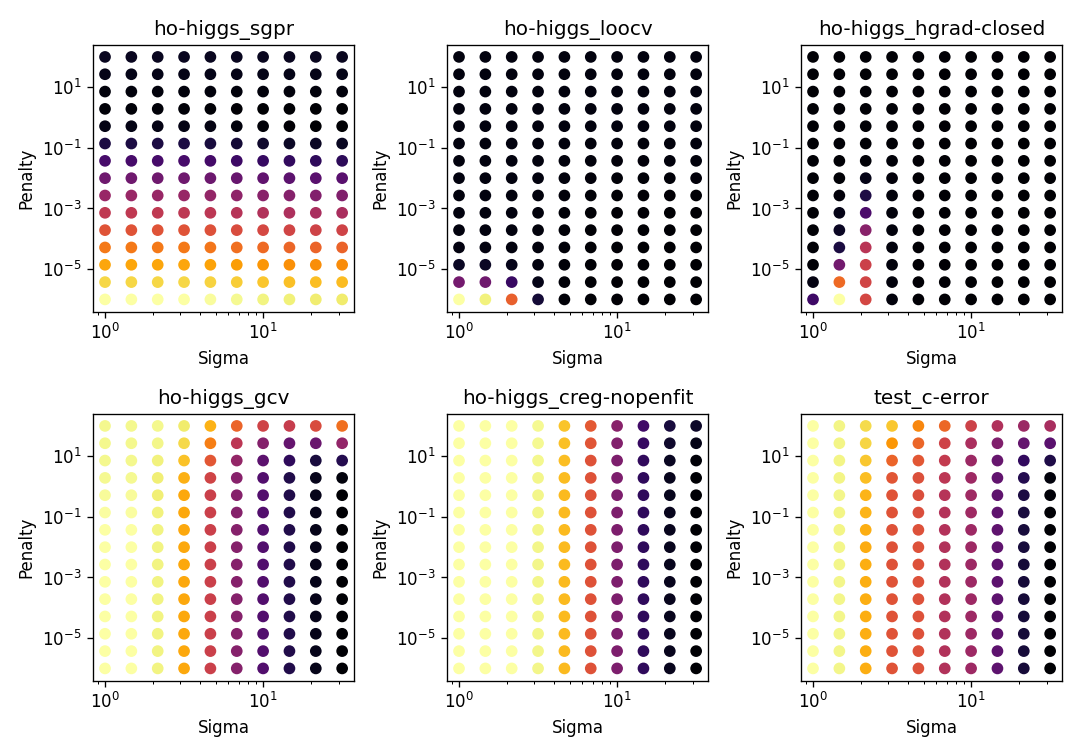

In [202]:
## test_exp_1 (m=20)
plot_all_models('energy', dict_loc)
plot_all_models('boston', dict_loc)
plot_all_models('ho-higgs', dict_loc, err_name='c-error')

## Optimization

In [3]:
DEFAULT_MODEL_NAMES = ("gcv", "loocv", "sgpr", "hgrad-closed", "hgrad-ift", "creg-penfit", "creg-nopenfit")

def gen_data_loc_hopt(e_name, dset, model_names=DEFAULT_MODEL_NAMES):
    d = {}
    for model_name in model_names:
        f = f"../benchmark/logs/{dset}_hopt_{model_name}_{e_name}*.pkl"
        all_exp_names = glob.glob(f)
        first_match_regex = re.compile(f"../benchmark/logs/{dset}_hopt_{model_name}_{e_name}(_\d+)?.pkl")
        matches = [first_match_regex.match(f) for f in all_exp_names]
        all_exp_names = [match.group() for match in matches if match is not None]
        if len(all_exp_names) == 0:
            continue
        elif len(all_exp_names) == 1:
            exp_name = all_exp_names[0]
        else:
            exp_runs = {}
            for try_exp_name in all_exp_names:
                regex = re.compile(".*_(\d+)\.pkl")
                match = regex.match(try_exp_name)
                if match is not None:
                    exp_runs[int(match.group(1))] = try_exp_name
            if len(exp_runs) == 0:
                raise ValueError("No exp-name among %s was matched" % (all_exp_names))
            exp_name = exp_runs[max(exp_runs.keys())]
            print("Taking experiment %s out of %d possible" % (exp_name, len(all_exp_names)))

        if os.path.isfile(exp_name):
            d[f"{dset}_{model_name}"] = exp_name
    return d

def all_exp_replicas(e_name, dset, model_names=DEFAULT_MODEL_NAMES):
    d = defaultdict(list)
    for model_name in model_names:
        f = f"../benchmark/logs/{dset}_hopt_{model_name}_{e_name}*.pkl"
        all_exp_names = glob.glob(f)
        first_match_regex = re.compile(f"../benchmark/logs/{dset}_hopt_{model_name}_{e_name}(_\d+)?.pkl")
        matches = [first_match_regex.match(f) for f in all_exp_names]
        all_exp_names = [match.group() for match in matches if match is not None]

        for exp_name in all_exp_names:
            if os.path.isfile(exp_name) and exp_name.endswith(".pkl"):
                d[f"{dset}_{model_name}"].append(exp_name)
    return d

In [4]:
def get_clims(dict_locs, model_attr_list):
    cmin, cmax = 1e99, -1e99
    if not isinstance(dict_locs, list):
        dict_locs = [dict_locs]

    for dict_loc in dict_locs:
        for i, (obj_name, attr) in enumerate(model_attr_list):
            cmin = min(cmin, min([el[attr] for el in dict_loc[obj_name][1:]]))
            cmax = max(cmax, max([el[attr] for el in dict_loc[obj_name][1:]]))
    return cmin, cmax

def get_scalar(num):
    if isinstance(num, torch.Tensor):
        return num.item()
    return num

def opt_plot_pensig(obj_name, dict_loc, fig, ax, attr, vmin=None, vmax=None, 
                    plot_start_end=True, cbar=True, **kwargs):
    """ Plot a single error trajectory on given fig,ax """   
    cdict = dict_loc[obj_name]
    # See line:154, training.py: the `pred_dict` is empty at first epoch, so we
    # exclude epoch 0 from all data.
    sigmas = [get_scalar(el['hp_sigma']) for el in cdict[1:]]
    penalties = [el['hp_penalty'] for el in cdict[1:]]
    loss = np.asarray([el[attr].item() for el in cdict[1:]])
    # Error color normalization
    norm = plt.Normalize(vmin or loss.min(), vmax or loss.max())
    
    # Generate line-segments for plotting
    points = np.array([sigmas, penalties]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1) 
    lc = LineCollection(segments, norm=norm, **kwargs)
    lc.set_array(loss)
    lc.set_linewidth(kwargs.get('linewidth', 1))
    line = ax.add_collection(lc)
    if cbar:
        fig.colorbar(line, ax=ax)
    
    if plot_start_end:
        start = segments[0,0]
        end = segments[-1,1]
        ax.scatter(start[0], start[1], marker='*', s=50, c='k')
        ax.scatter(end[0], end[1], marker='X', s=50, c='k')
    
    ax.set_xlim([np.min(sigmas) -1, np.max(sigmas) + 1])
    ax.set_ylim([np.min(penalties) -1, np.max(penalties) + 1])
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Penalty')
    ax.set_title(obj_name)

def opt_plot_all_models(dset, data_dict, err_name='test_NRMSE', cbar=False, exp_name=None,
                        model_names=("sgpr", "loocv", "gcv", "creg-nopenfit", "hgrad-closed")):
    """plot all the models for a given experiment/dataset pair"""
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
    ax = ax.flatten()
    model_attribs = [(f"{dset}_{mname}", err_name) for mname in model_names]
    # vmin, vmax determine the coloring of the trajectories (i.e. how the error is displayed)
    # they are initialized as the overall min and max for all models considered.
    vmin, vmax = get_clims(data_dict, model_attribs)
    # reduce dynamic range for high errors: 
    # we want more detail on low-error portions of the plot.
    vmax -= (vmax - vmin) / 2

    for i, (obj_name, attr) in enumerate(model_attribs):
        opt_plot_pensig(obj_name, data_dict, fig, ax[i], attr, 
                        cmap='tab20', linewidth=4, vmin=vmin, vmax=vmax)

    if exp_name is not None:
        fig.suptitle(exp_name)
    if cbar:  # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.89, 0.15, 0.05, 0.7])
        fig.colorbar(ax[0].collections[0], cax=cbar_ax)
        fig.tight_layout(rect=(0, 0, 0.87, 1))
    else:
        fig.tight_layout()
        
def pensig_opt_multiexp(dset, exp_dicts, err_name='test_NRMSE', cbar=False, exp_name=None,
                        model_names=("sgpr", "loocv", "gcv", "creg-nopenfit", "hgrad-closed")):
    """ For each model (as defined in this function), plot all trajectories from exp_dicts. """
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
    ax = ax.flatten()
    model_attribs = [(f"{dset}_{mname}", err_name) for mname in model_names]
    # vmin, vmax determine the coloring of the trajectories (i.e. how the error is displayed)
    # they are initialized as the overall min and max for all models considered.
    vmin, vmax = get_clims(exp_dicts, model_attribs)
    # reduce dynamic range for high errors: 
    # we want more detail on low-error portions of the plot.
    vmax -= (vmax - vmin) / 1.2

    ax_xlims = [[np.inf, -np.inf] for _ in ax]
    ax_ylims = [[np.inf, -np.inf] for _ in ax]
    for j, exp_dict in enumerate(exp_dicts):
        for i, (obj_name, attr) in enumerate(model_attribs):
            opt_plot_pensig(obj_name, exp_dict, fig, ax[i], attr, 
                            cmap='tab20', linewidth=4, vmin=vmin, vmax=vmax,
                            cbar=False)
            ax_xlims[i][0] = min(ax_xlims[i][0], ax[i].get_xlim()[0])
            ax_xlims[i][1] = max(ax_xlims[i][1], ax[i].get_xlim()[1])
            ax_ylims[i][0] = min(ax_ylims[i][0], ax[i].get_ylim()[0])
            ax_ylims[i][1] = max(ax_ylims[i][1], ax[i].get_ylim()[1])
    for i in range(len(model_attribs)):
        ax[i].set_xlim(ax_xlims[i][0], ax_xlims[i][1])
        ax[i].set_ylim(ax_ylims[i][0], ax_ylims[i][1])
    
    if exp_name is not None:
        fig.suptitle(exp_name)
    if cbar:  # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.87, 0.15, 0.05, 0.7])
        cbar = fig.colorbar(ax[0].collections[0], cax=cbar_ax)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label(err_name, rotation=270)
        fig.tight_layout(rect=(0, 0, 0.89, 1))
    else:
        fig.tight_layout()

In [5]:
def plot_hopt_exp(exp_name, dataset):
    """ Load the data, and plot all the models for a given experiment/dataset pair"""
    data_loc = gen_data_loc_hopt(exp_name, dataset)
    # keys will be e.g. boston_loocv (dset_model)
    data = {}
    for k, v in data_loc.items():
        with open(v, 'rb') as fh:
            data[k] = pickle.load(fh)
    opt_plot_all_models(dataset, data, exp_name=exp_name)

def plot_hopt_multiexp(exp_names, dataset):
    exp_dicts = []
    for exp_name in exp_names:
        data_paths = gen_data_loc_hopt(exp_name, dataset)
        data = {}
        for k, v in data_paths.items():
            with open(v, 'rb') as fh:
                data[k] = pickle.load(fh)
        exp_dicts.append(data)
    pensig_opt_multiexp(dataset, exp_dicts, cbar=True, exp_name=",".join(exp_names))
    
def plot_hopt_valsizes_multiexp(exp_names, val_sizes, dataset):
    exp_dicts = []
    for exp_name in exp_names:
        data = {}
        for val_size in val_sizes:
            data_paths = gen_data_loc_hopt(exp_name + val_size, dataset)
            assert len(data_paths) == 1
            for k, v in data_paths.items():
                with open(v, 'rb') as fh:
                    data['%s_%s' % (dataset, val_size)] = pickle.load(fh)
        exp_dicts.append(data)
    pensig_opt_multiexp(dataset, exp_dicts, err_name='test_NRMSE', 
                        cbar=True, exp_name="Hgrad-Closed Val sizes",
                        model_names=val_sizes)

In [6]:
def fetch_row(data, row_name):
    return np.asarray([el[row_name].item() for el in data[1:]])

def fetch_err_diff(data, row_name):
    err_name = row_name.split("_")[1]
    tr_err_name = f"train_{err_name}"
    ts_err_name = f"test_{err_name}"
    tr_row = fetch_row(data, tr_err_name)
    ts_row = fetch_row(data, ts_err_name)
    return ts_row - tr_row

def _plot_single_error_traj(dset, exp_dict, err_name, model_names, exp_name, extract_ts=None, title=None):
    if extract_ts is None:
        extract_ts = fetch_row
    fig, ax = plt.subplots()
    
    for model in model_names:
        dset_model = f"{dset}_{model}"
        model_data_list = exp_dict[dset_model]
        err_data = []
        for model_data in model_data_list:
            err_data.append(extract_ts(model_data, err_name))
        max_exp_len = max(len(ed) for ed in err_data)
        err_data = [np.pad(ed, (0, max_exp_len - len(ed)), mode='edge') for ed in err_data]
        err_data = np.stack(err_data, axis=0)
        err_data_mean = np.mean(err_data, axis=0)
        err_data_std = np.std(err_data, axis=0)
        
        xs = np.arange(1, len(err_data_mean) + 1)
        
        line = ax.plot(xs, err_data_mean, label=model, lw=1, linestyle='-')
        ax.fill_between(xs, err_data_mean - err_data_std, err_data_mean + err_data_std,
                        color=line[-1].get_color(), alpha=0.2)
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel(err_name)
    if title is None:
        title = exp_name
    ax.set_title(title)
    ax.legend(loc='best')
    fig.tight_layout()
    
def plot_single_error_traj(exp_name, dataset, model_names, extract_ts=None, title=None):
    """ Load the data, and plot all the models for a given experiment/dataset pair"""
    
    exp_paths = all_exp_replicas(exp_name, dataset, model_names)
    # keys will be e.g. boston_loocv (dset_model), values will be list of paths
    data = defaultdict(list)
    for dset_model, paths in exp_paths.items():
        for path in paths:
            with open(path, 'rb') as fh:
                data[dset_model].append(pickle.load(fh))
    _plot_single_error_traj(dataset, data, "test_NRMSE", model_names, exp_name,
                            extract_ts=extract_ts, title=title)
    
def plot_multi_error_traj(exp_names, dataset, model_name, exp_labels, title="", extract_ts=None):
    """ Load the data, and plot all the models for a given experiment/dataset pair"""
    
    data = defaultdict(list)
    for i in range(len(exp_names)):
        # keys will be e.g. boston_loocv (dset_model), values will be list of paths
        exp_paths = all_exp_replicas(exp_names[i], dataset, [model_name])
        # new key has the experiment label instead of the model
        new_key = f"{dataset}_{exp_labels[i]}"
        assert len(exp_paths) == 1
        for dset_model, paths in exp_paths.items():
            for path in paths:
                with open(path, 'rb') as fh:
                    data[new_key].append(pickle.load(fh))
    _plot_single_error_traj(dataset, data, "test_NRMSE", exp_labels, title,
                            extract_ts=extract_ts)

### Oldish Experiments

<IPython.core.display.Javascript object>


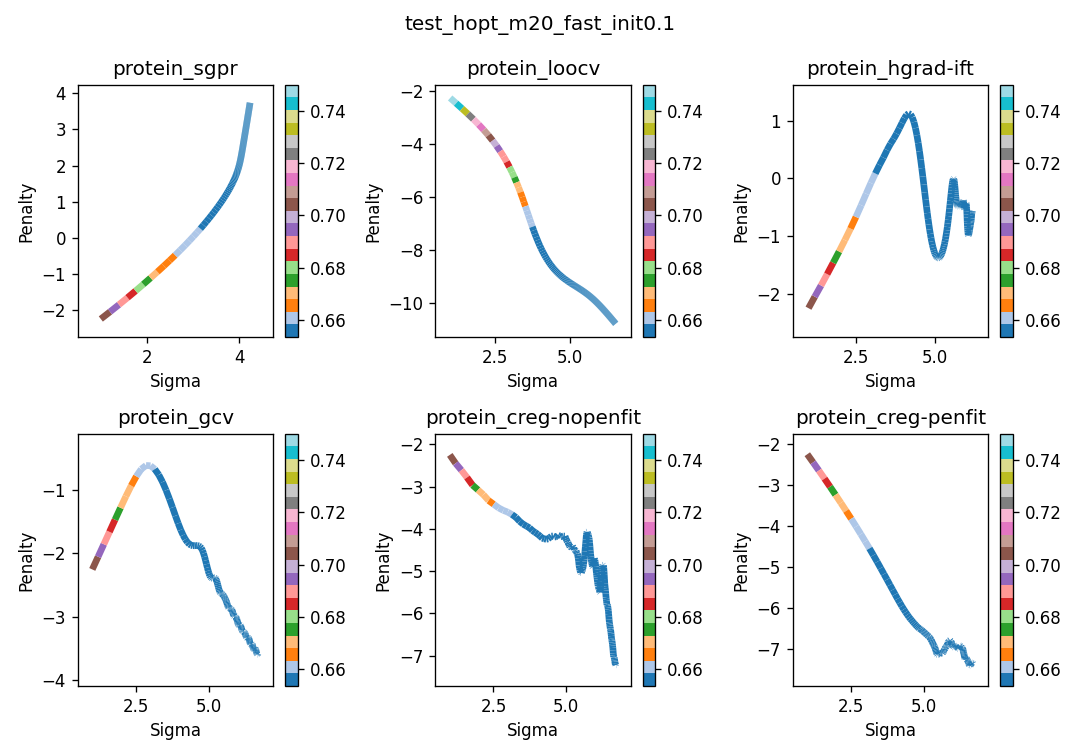

In [42]:
plot_hopt_exp("test_hopt_m20_fast_init0.1", "protein")

<IPython.core.display.Javascript object>


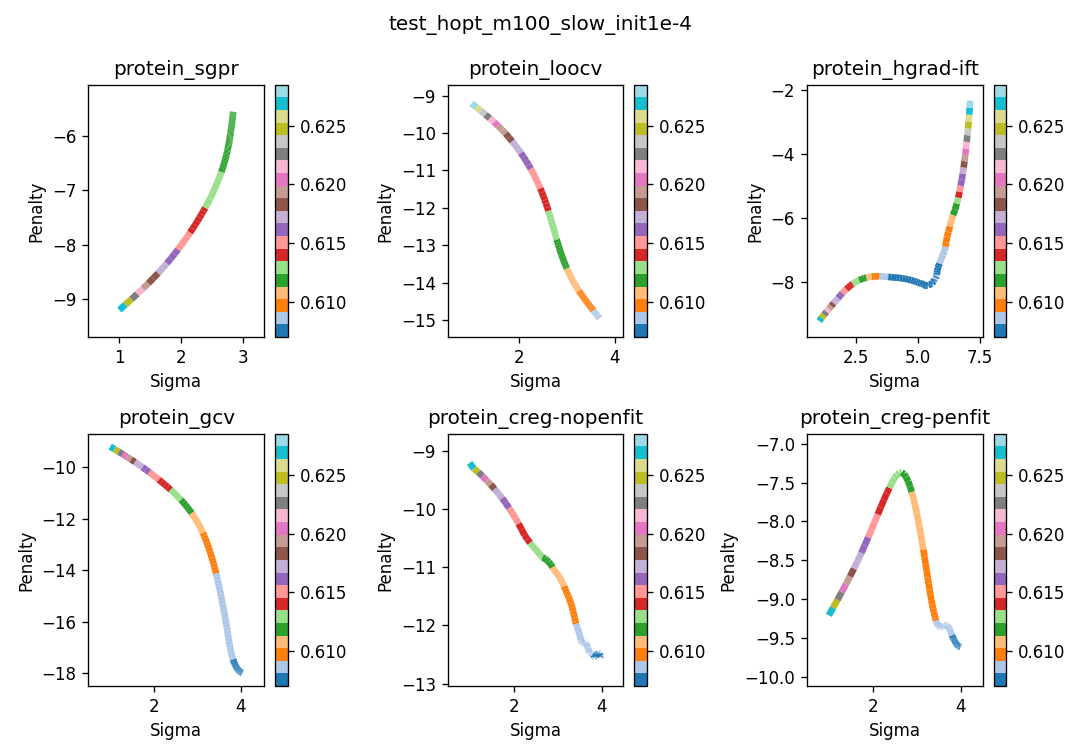

In [56]:
plot_hopt_exp("test_hopt_m100_slow_init1e-4", "protein")

<IPython.core.display.Javascript object>


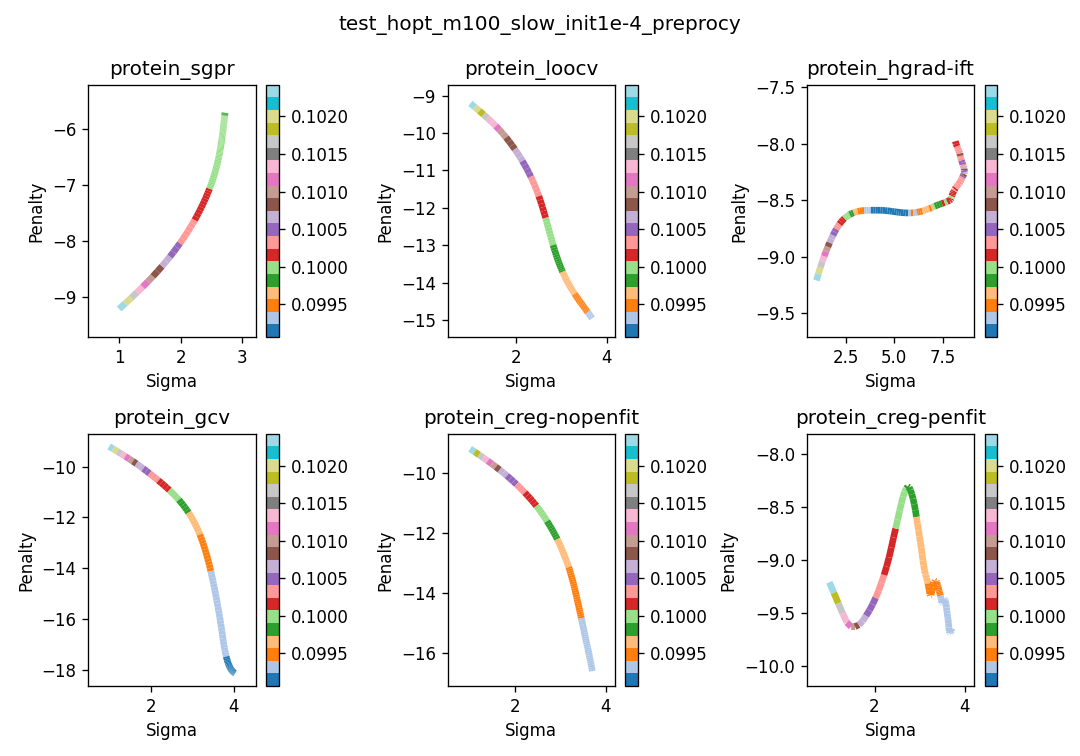

In [55]:
plot_hopt_exp("test_hopt_m100_slow_init1e-4_preprocy", "protein")

<IPython.core.display.Javascript object>


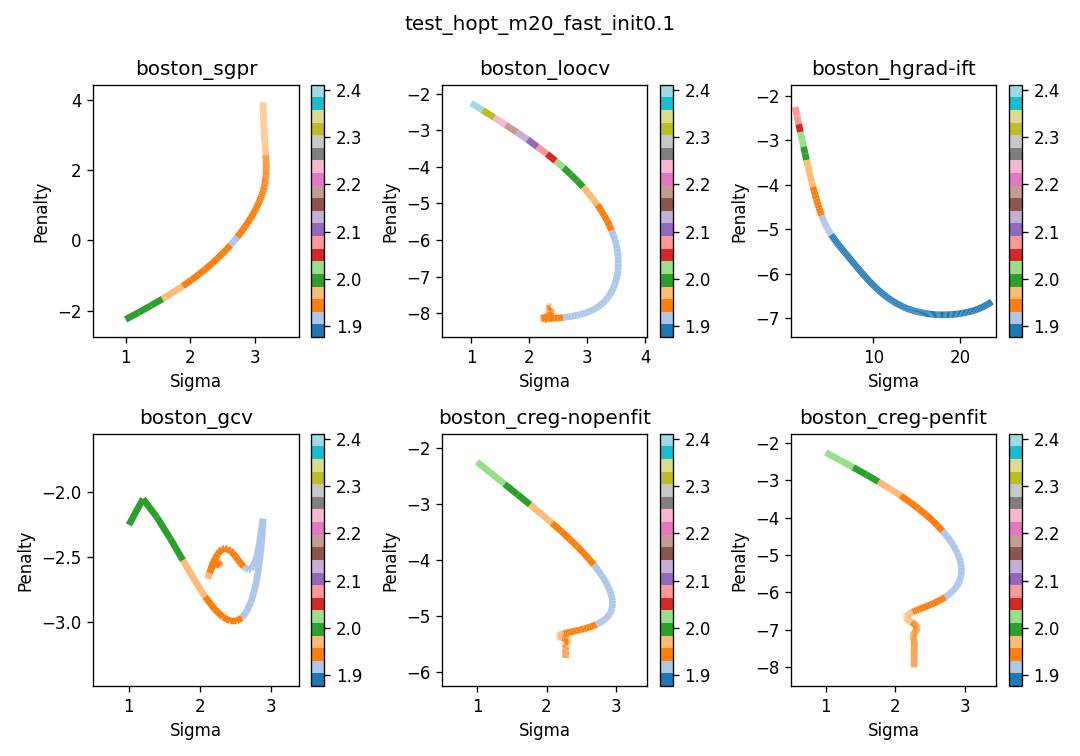

In [43]:
plot_hopt_exp("test_hopt_m20_fast_init0.1", "boston")

<IPython.core.display.Javascript object>


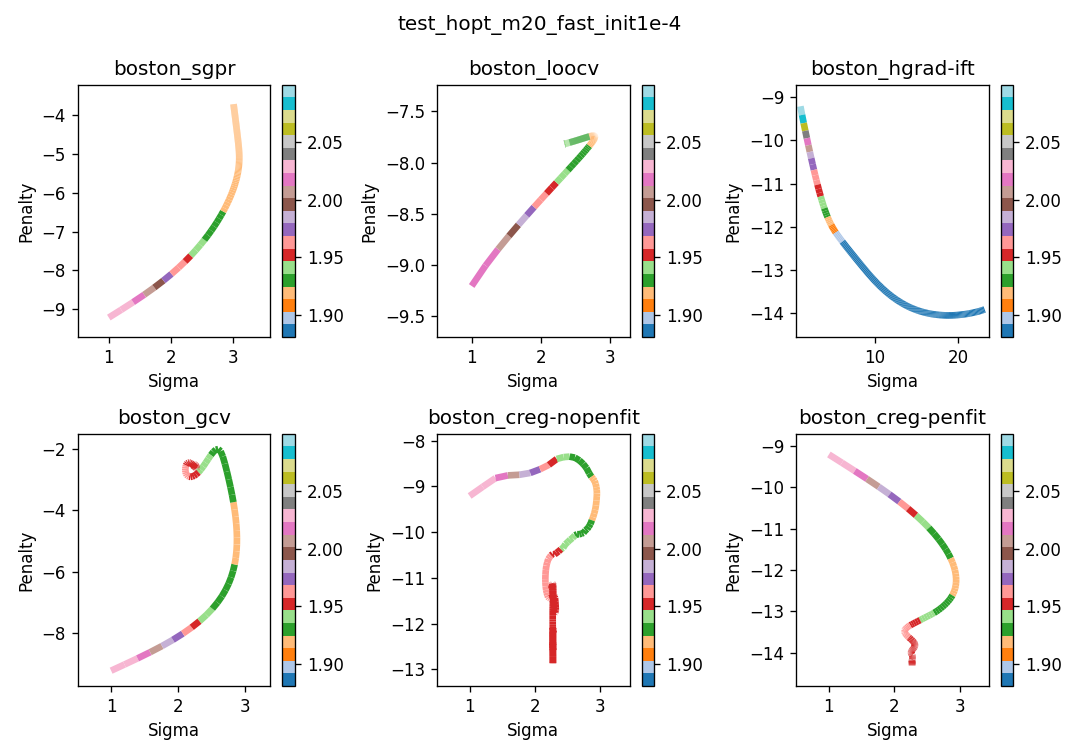

In [44]:
plot_hopt_exp("test_hopt_m20_fast_init1e-4", "boston")

In [ ]:
plot_hopt_exp("test_hopt_m20_slow_init1e-4", "boston")

<IPython.core.display.Javascript object>


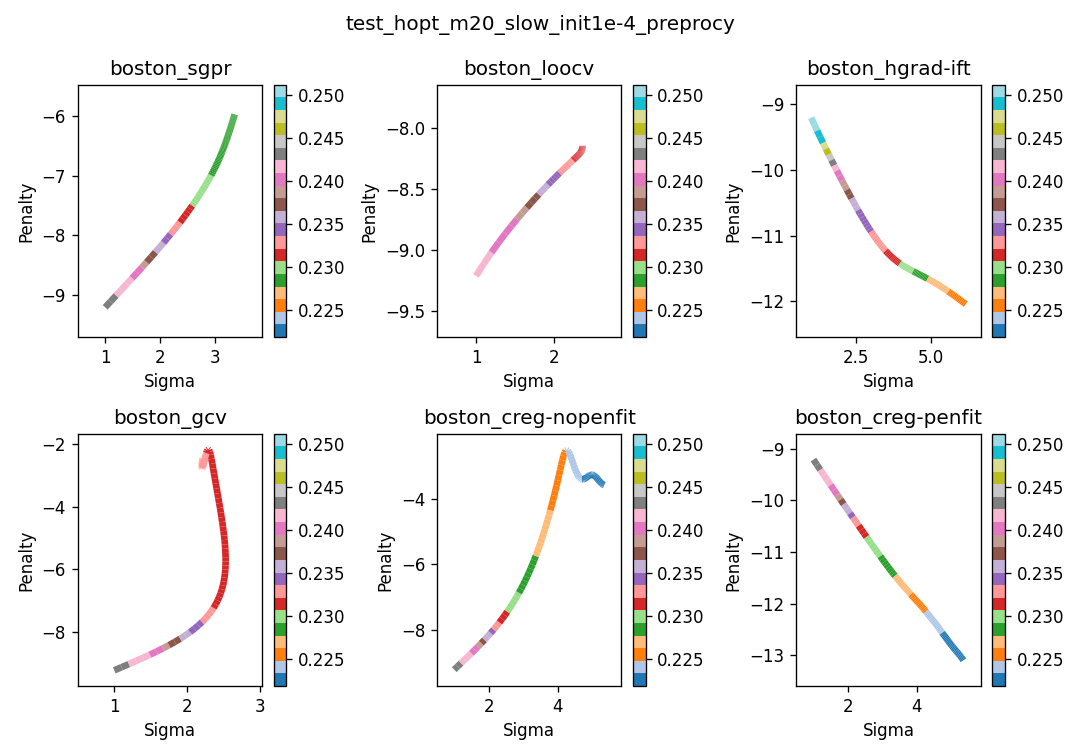

In [53]:
plot_hopt_exp("test_hopt_m20_slow_init1e-4_preprocy", "boston")

<IPython.core.display.Javascript object>


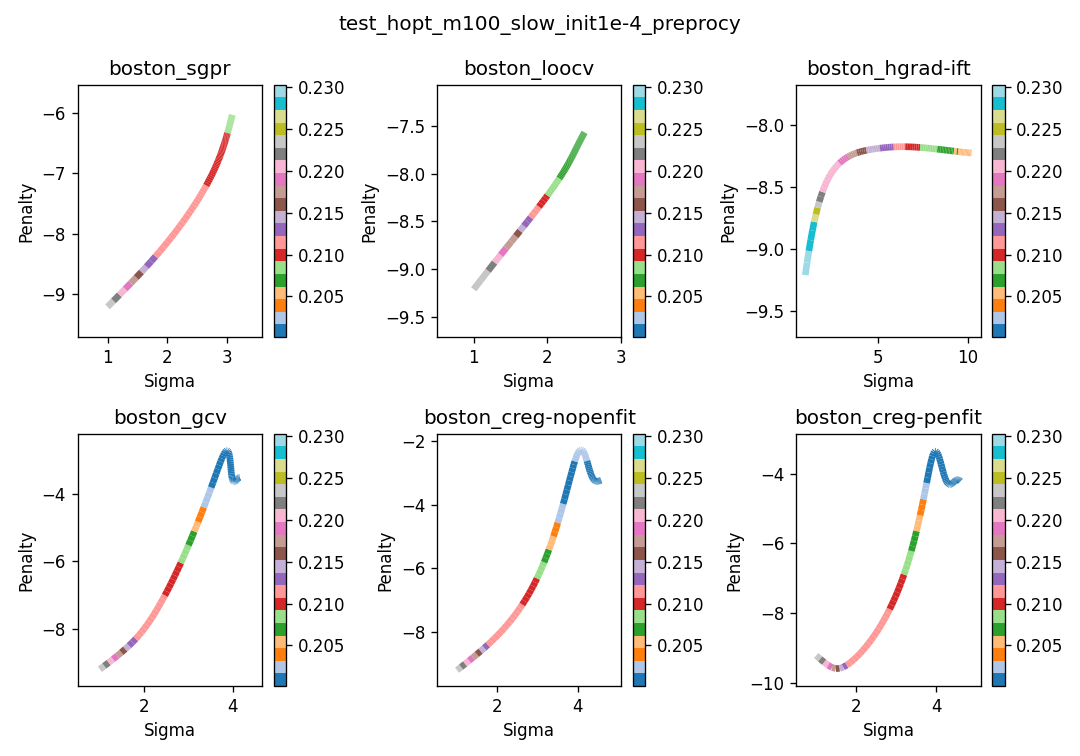

In [54]:
plot_hopt_exp("test_hopt_m100_slow_init1e-4_preprocy", "boston")

<IPython.core.display.Javascript object>


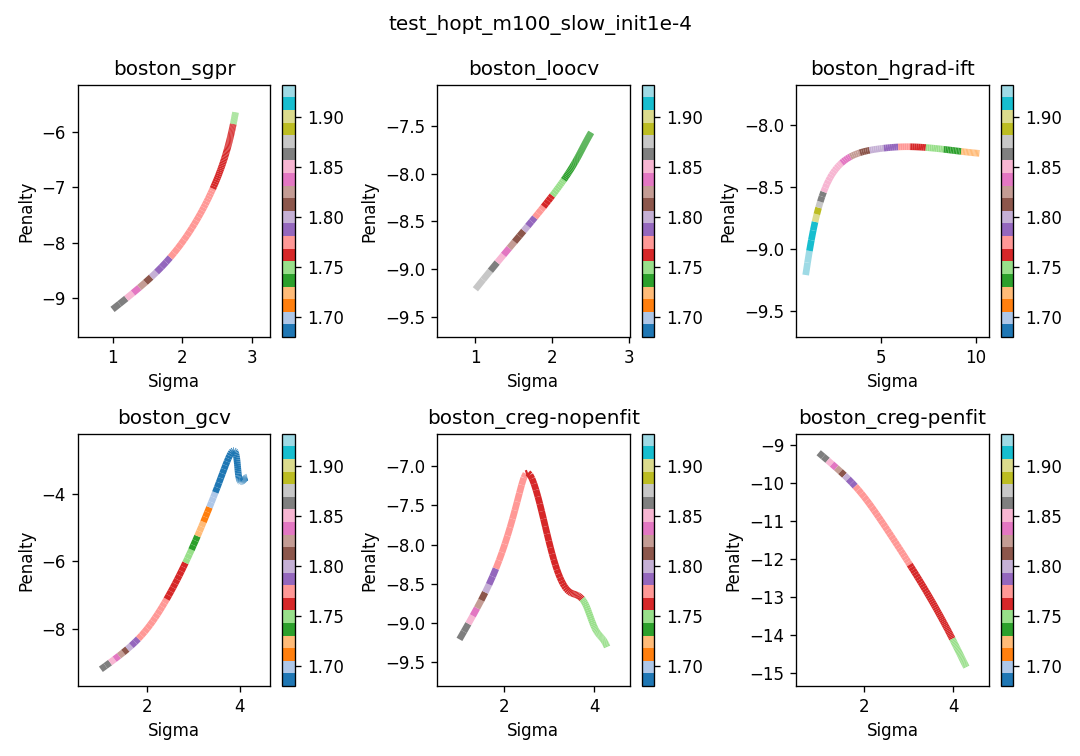

In [51]:
plot_hopt_exp("test_hopt_m100_slow_init1e-4", "boston")

<IPython.core.display.Javascript object>


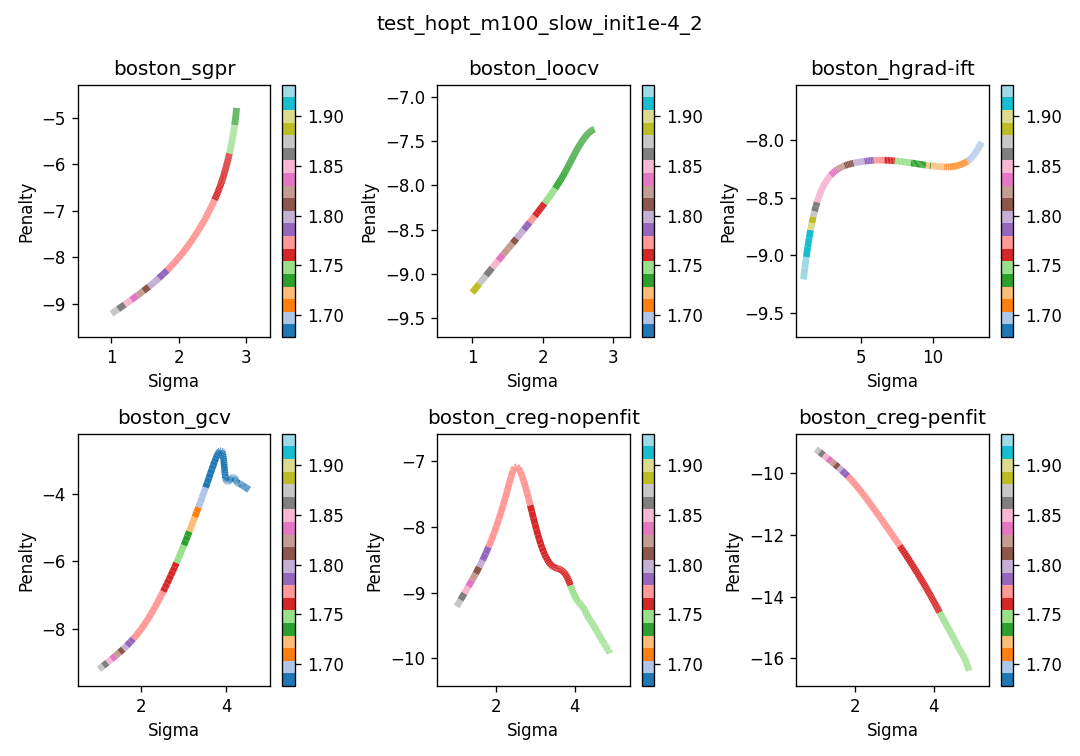

In [52]:
plot_hopt_exp("test_hopt_m100_slow_init1e-4_2", "boston")

In [ ]:
plot_hopt_exp("test_hopt_m20_lr0.05_pinit1sinit1", "boston")
# plot_hopt_exp("test_hopt_m20_lr0.05_pinit1e-4sinit1", "boston")
# plot_hopt_exp("test_hopt_m20_lr0.05_pinit1e-4sinit15", "boston")
# plot_hopt_exp("test_hopt_m20_lr0.05_pinit1sinit15", "boston")
plot_hopt_exp("test_hopt_m20_slow_init1e-4", "energy")
plot_hopt_exp("test_hopt_m100_slow_init1e-4_preprocy", "energy")
plot_hopt_exp("test_hopt_m20_lr0.05_init1e-4", "energy")
plot_hopt_exp("test_hopt_m20_lr0.05_init1", "energy")
plot_hopt_exp("test_hopt_m20_lr0.05_pinit1sinit15", "energy")

### Multiple Starting points

#### Energy

<IPython.core.display.Javascript object>


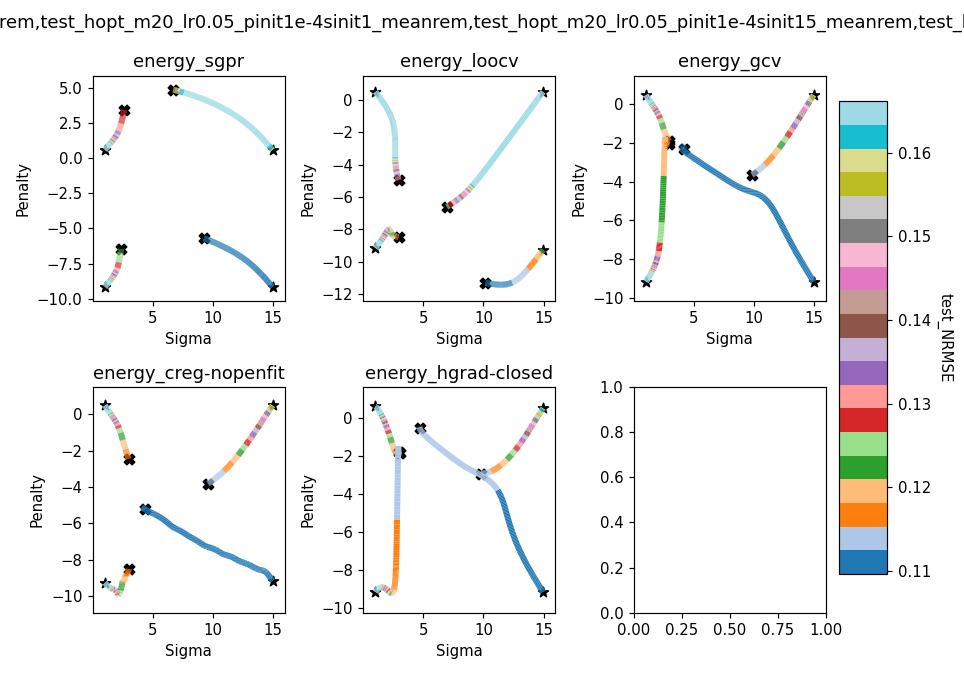

<ipython-input-166-a8c868e879ef>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [167]:
# Y preproc: mean-removal only
plot_hopt_multiexp([
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit15_meanrem",
    "test_hopt_m20_lr0.05_pinit1sinit15_meanrem",
], "energy")

#### Boston

<IPython.core.display.Javascript object>


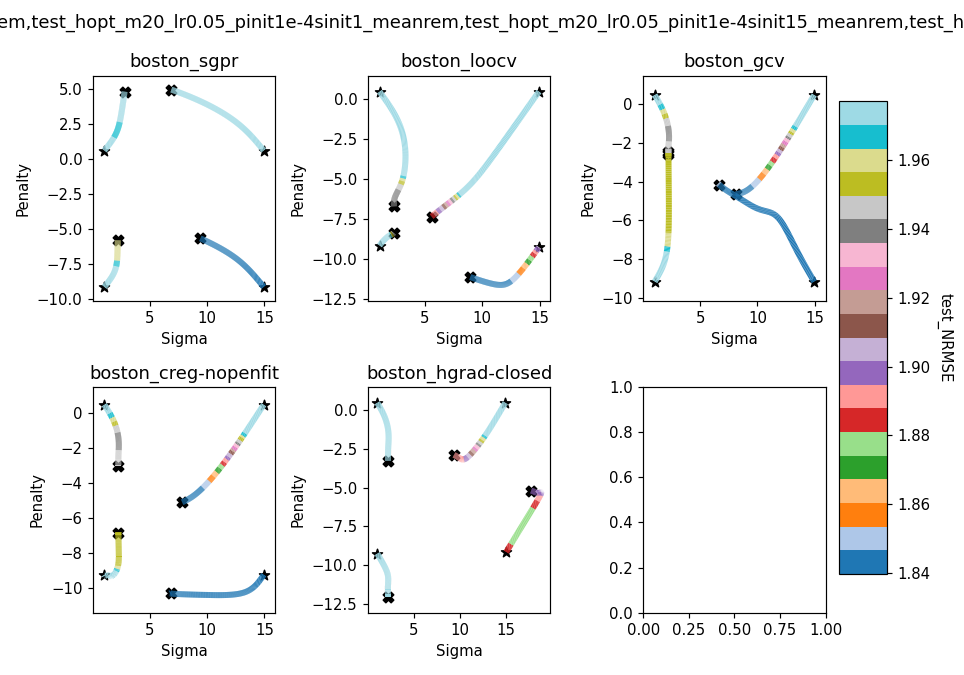

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [206]:
# Y preproc: mean-removal only
plot_hopt_multiexp([
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit15_meanrem",
    "test_hopt_m20_lr0.05_pinit1sinit15.0_meanrem",
], "boston")

<IPython.core.display.Javascript object>


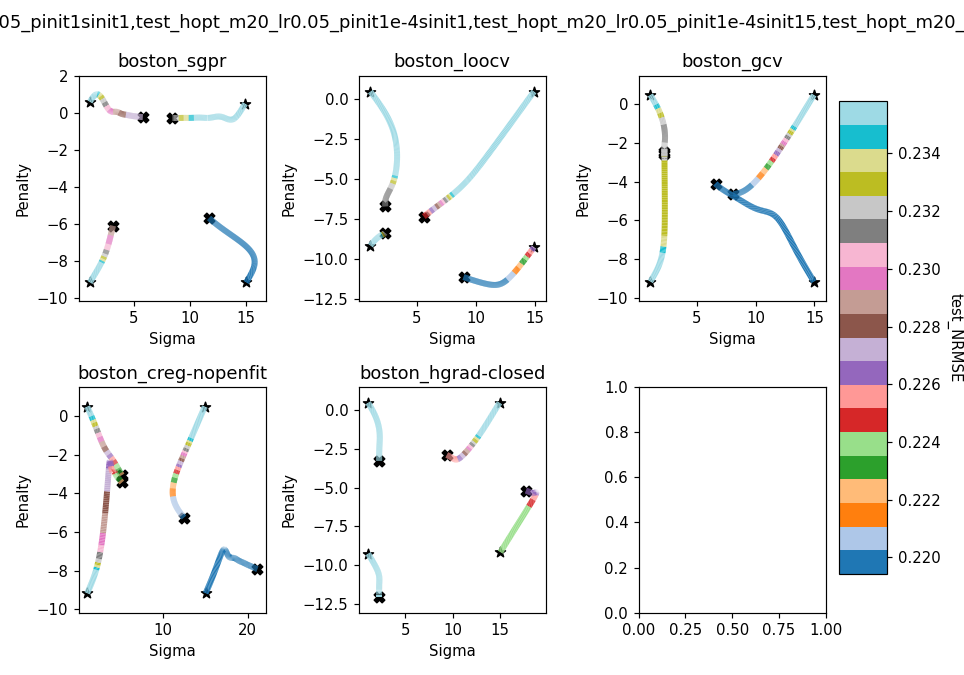

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [207]:
# Y preproc: y_standardize
plot_hopt_multiexp([
    "test_hopt_m20_lr0.05_pinit1sinit1",
    "test_hopt_m20_lr0.05_pinit1e-4sinit1",
    "test_hopt_m20_lr0.05_pinit1e-4sinit15",
    "test_hopt_m20_lr0.05_pinit1sinit15",
], "boston")

#### Protein

Taking experiment ../benchmark/logs/protein_hopt_sgpr_test_hopt_m20_lr0.05_pinit1sinit1_meanrem_3.pkl out of 3 possible


<IPython.core.display.Javascript object>


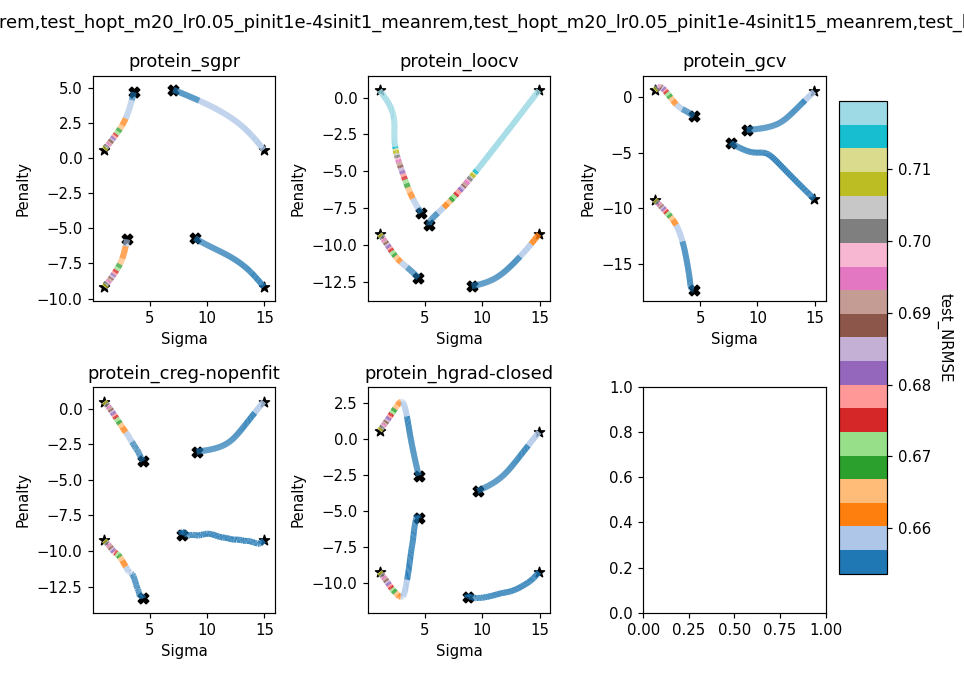

<ipython-input-156-fca0b1e95fd0>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [160]:
# Y preproc: mean removal only
plot_hopt_multiexp([
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem",
    "test_hopt_m20_lr0.05_pinit1e-4sinit15_meanrem",
    "test_hopt_m20_lr0.05_pinit1sinit15_meanrem",
], "protein")

In [172]:
print()

### Experiment with varying val-pct (only hgrad-closed)
Exp name: ./logs/energy_hopt_hgrad-closed_test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val0.8.pkl

<IPython.core.display.Javascript object>


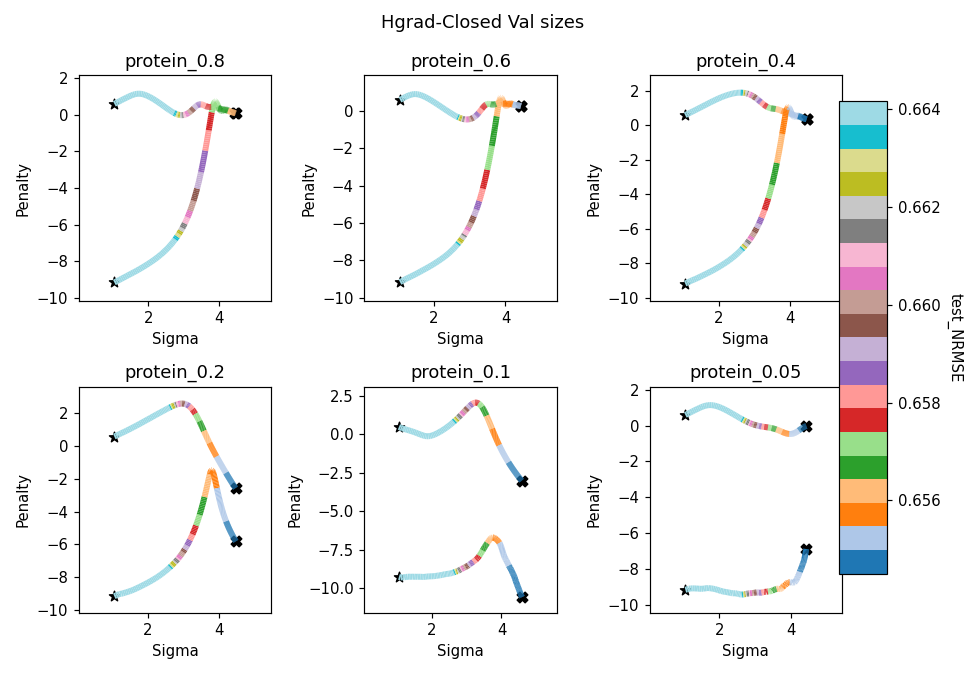

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [201]:
exp_names = [
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val",
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem_val",
]
val_sizes = ["0.8", "0.6", "0.4", "0.2", "0.1", "0.05"]
plot_hopt_valsizes_multiexp(exp_names, val_sizes, dataset="protein")

Taking experiment ../benchmark/logs/energy_hopt_hgrad-closed_test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val0.8_2.pkl out of 2 possible
Taking experiment ../benchmark/logs/energy_hopt_hgrad-closed_test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val0.6_2.pkl out of 2 possible
Taking experiment ../benchmark/logs/energy_hopt_hgrad-closed_test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val0.4_2.pkl out of 2 possible
Taking experiment ../benchmark/logs/energy_hopt_hgrad-closed_test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val0.2_2.pkl out of 2 possible


<IPython.core.display.Javascript object>


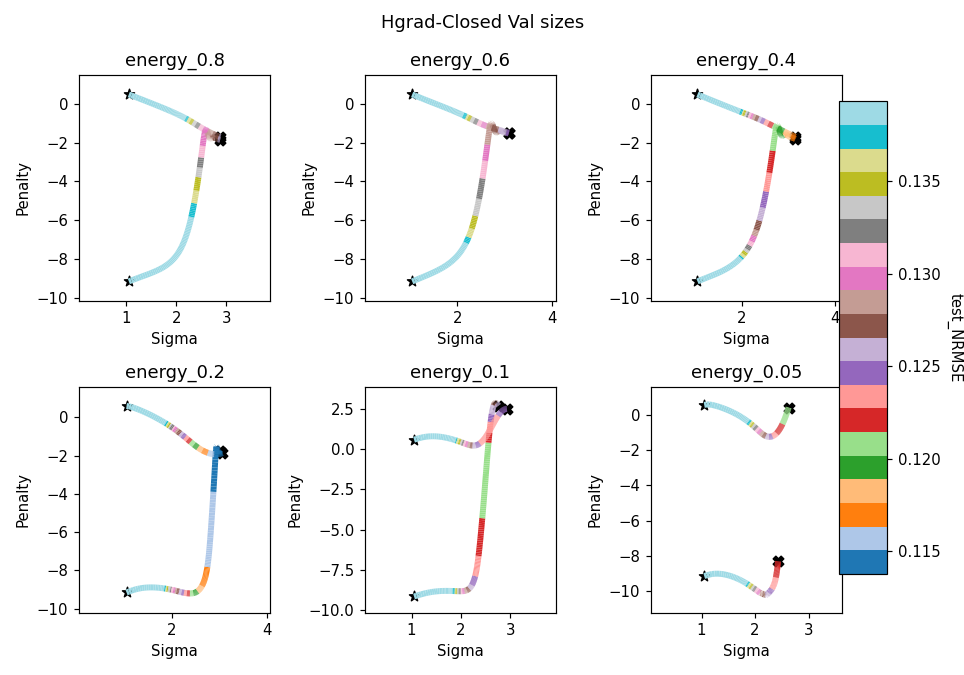

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [203]:
exp_names = [
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val",
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem_val",
]
val_sizes = ["0.8", "0.6", "0.4", "0.2", "0.1", "0.05"]
plot_hopt_valsizes_multiexp(exp_names, val_sizes, dataset="energy")

<IPython.core.display.Javascript object>


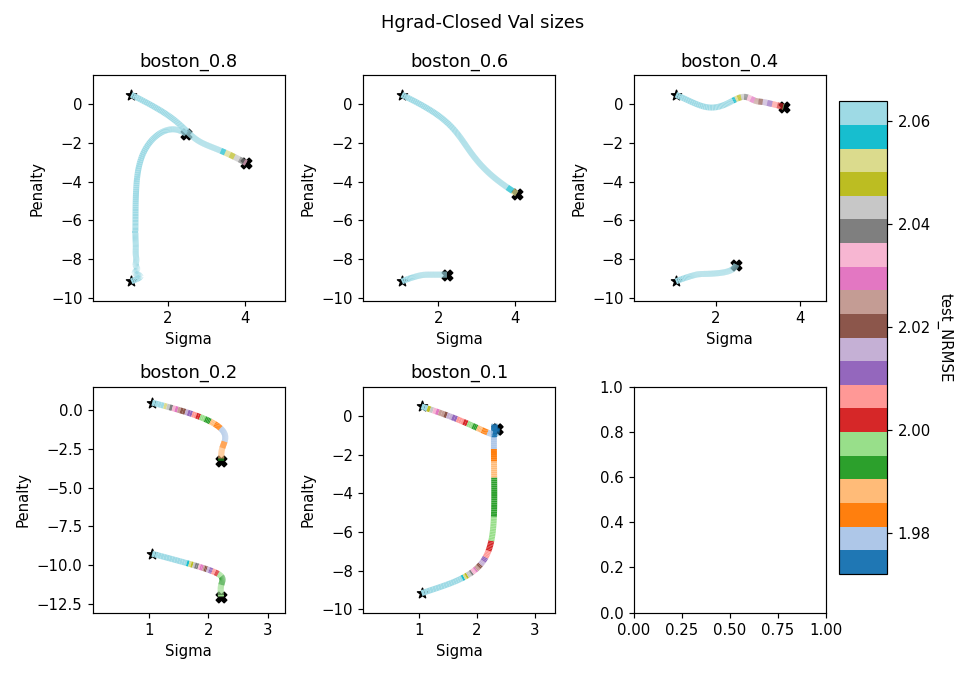

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [200]:
exp_names = [
    "test_hopt_m20_lr0.05_pinit1e-4sinit1_meanrem_val",
    "test_hopt_m20_lr0.05_pinit1sinit1_meanrem_val",
]
val_sizes = ["0.8", "0.6", "0.4", "0.2", "0.1"]
plot_hopt_valsizes_multiexp(exp_names, val_sizes, dataset="boston")

<IPython.core.display.Javascript object>


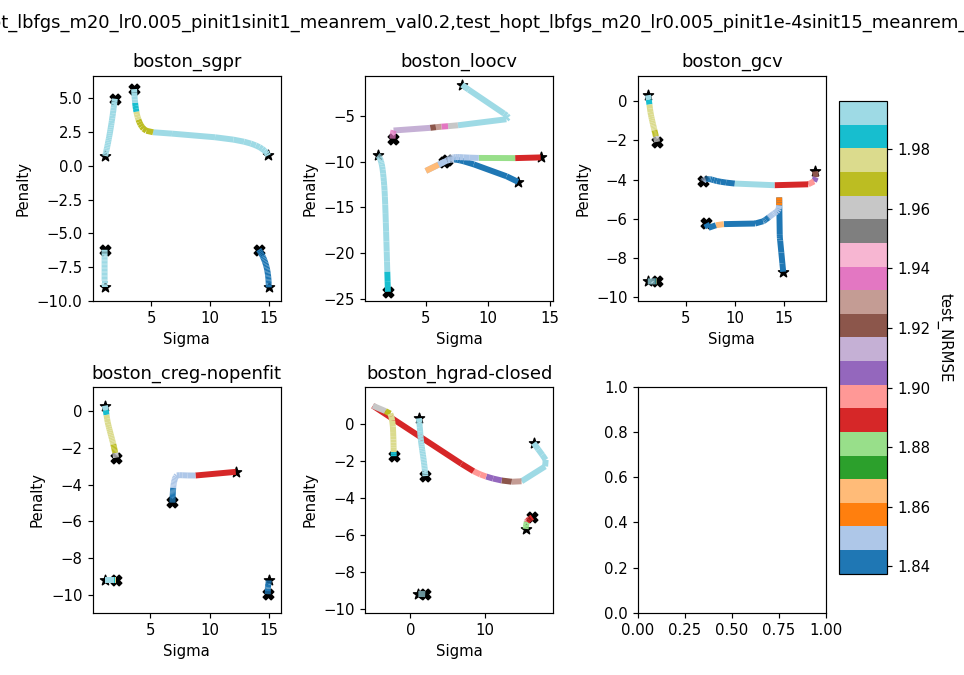

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [210]:
exp_names = [
    "test_hopt_lbfgs_m20_lr0.005_pinit1sinit15_meanrem_val0.2",
    "test_hopt_lbfgs_m20_lr0.005_pinit1sinit1_meanrem_val0.2",
    "test_hopt_lbfgs_m20_lr0.005_pinit1e-4sinit15_meanrem_val0.2",
    "test_hopt_lbfgs_m20_lr0.005_pinit1e-4sinit1_meanrem_val0.2",
]
plot_hopt_multiexp(exp_names, dataset="boston")

Taking experiment ../benchmark/logs/boston_hopt_loocv_test_hopt_rmsprop_m20_lr0.02_pinit1e-4sinit1_meanrem_val0.2_2.pkl out of 2 possible


<IPython.core.display.Javascript object>


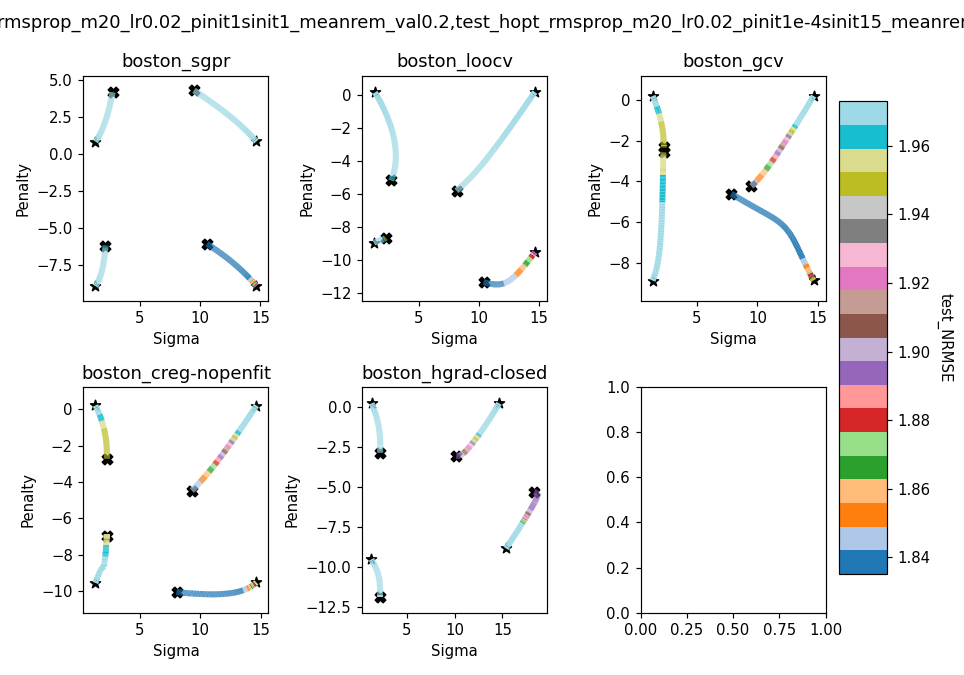

<ipython-input-191-b5f673a5f4f6>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.89, 1))


In [216]:
exp_names = [
    "test_hopt_rmsprop_m20_lr0.02_pinit1sinit15_meanrem_val0.2",
    "test_hopt_rmsprop_m20_lr0.02_pinit1sinit1_meanrem_val0.2",
    "test_hopt_rmsprop_m20_lr0.02_pinit1e-4sinit15_meanrem_val0.2",
    "test_hopt_rmsprop_m20_lr0.02_pinit1e-4sinit1_meanrem_val0.2",
]
plot_hopt_multiexp(exp_names, dataset="boston")

### Plot Optimization (validation percentage experiments, hgrad-closed model)

 - Hgrad-closed is impacted **very slightly** by different validation percentages when choosing 2 parameters. 
   20%, 40% and 60% seem to perform slightly better indipendently from the optimization algorithm.

<IPython.core.display.Javascript object>


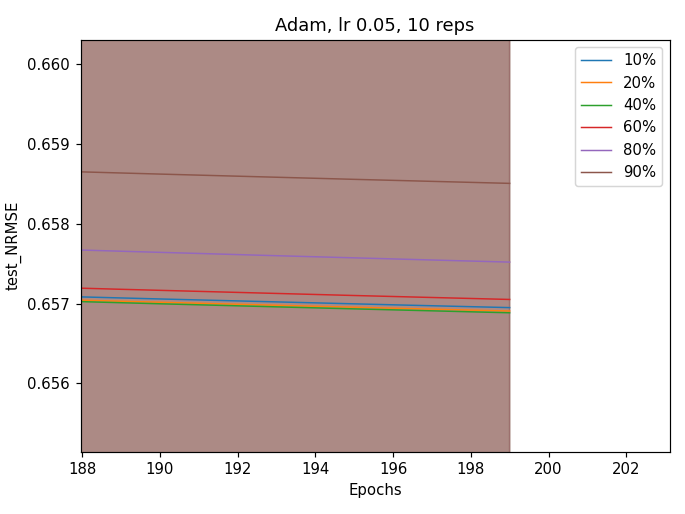

<IPython.core.display.Javascript object>


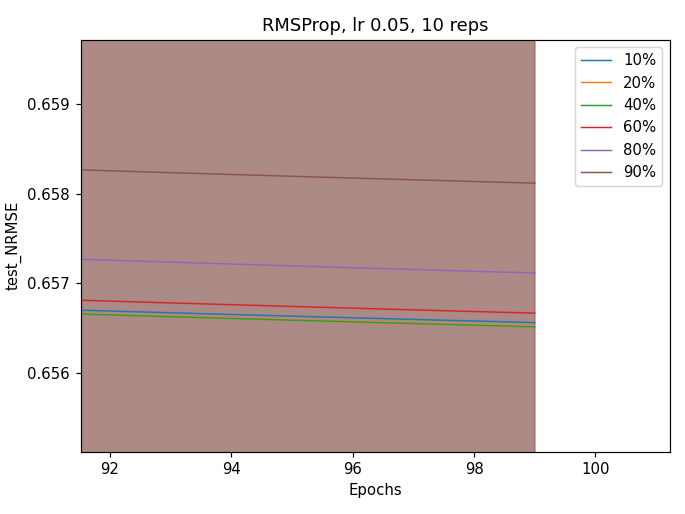

<IPython.core.display.Javascript object>


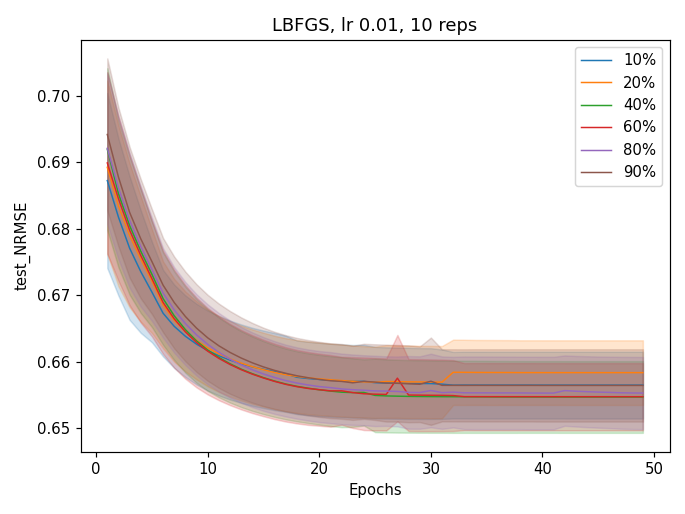

In [22]:
plot_multi_error_traj([
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.1",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.2",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.4",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.6",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.8",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.9",
], "protein", "hgrad-closed", ["10%", "20%", "40%", "60%", "80%", "90%"], title="Adam, lr 0.05, 10 reps")
plot_multi_error_traj([
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.1",
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.2",
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.4",
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.6",
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.8",
    "test_hopt_rmsprop_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.9",
], "protein", "hgrad-closed", ["10%", "20%", "40%", "60%", "80%", "90%"], title="RMSProp, lr 0.05, 10 reps")
plot_multi_error_traj([
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.1",
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.2",
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.4",
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.6",
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.8",
    "test_hopt_lbfgs_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.9",
], "protein", "hgrad-closed", ["10%", "20%", "40%", "60%", "80%", "90%"], title="LBFGS, lr 0.01, 10 reps")

Going to **multiple sigmas** does not change the picture!

<IPython.core.display.Javascript object>


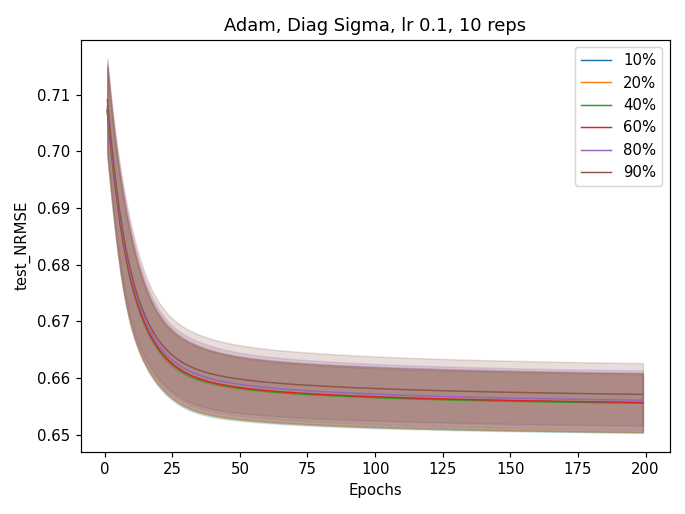

In [48]:
# Test with multiple sigmas (protein has d=9)
plot_multi_error_traj([
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.1_diagsig",
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.2_diagsig",
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.4_diagsig",
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.6_diagsig",
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.8_diagsig",
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.9_diagsig",
], "protein", "hgrad-closed", ["10%", "20%", "40%", "60%", "80%", "90%"], 
    title="Adam, Diag Sigma, lr 0.1, 10 reps",
    extract_ts=None)

On the contrary, adding center-optimization to the mix finally reveals some significant differences in accuracy
with different validation percentages.

**Note**: for this experiment we used learning-rate decay as follows:
```
schedule = torch.optim.lr_scheduler.StepLR(opt_hp, step_size=200, gamma=0.3)
```
and trained for 500 epochs.

<IPython.core.display.Javascript object>


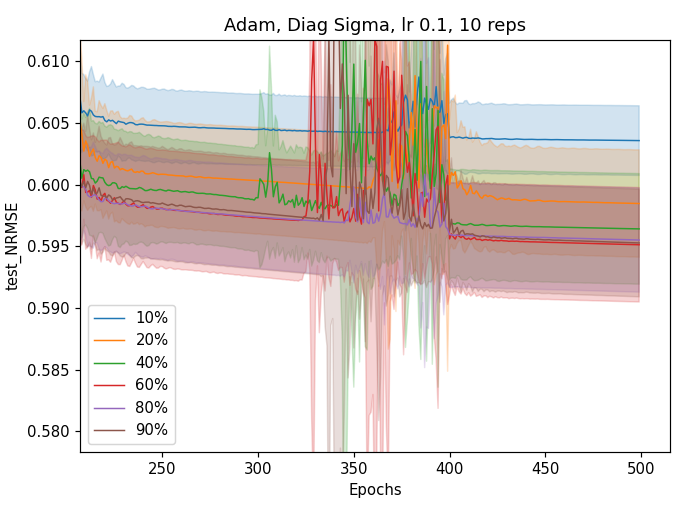

In [43]:
# Test with optimized centers (20) and multiple sigmas (protein has d=9)
plot_multi_error_traj([
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.1_diagsig_optM",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.2_diagsig_optM",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.4_diagsig_optM",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.6_diagsig_optM",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.8_diagsig_optM",
    "test_hopt_adam_m20_lr0.05_pinit1.0sinit1.0_meanrem_val0.9_diagsig_optM",
], "protein", "hgrad-closed", ["10%", "20%", "40%", "60%", "80%", "90%"], 
    title="Adam, Diag Sigma, lr 0.1, 10 reps",
    extract_ts=None)

### Plot optimization for different models 

<IPython.core.display.Javascript object>


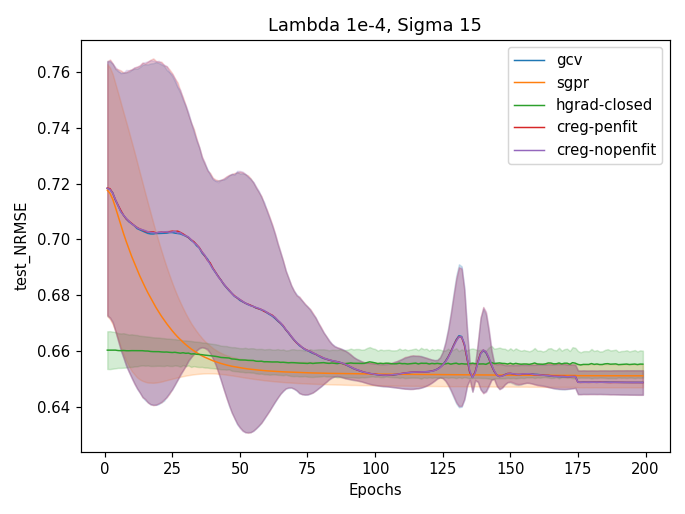

<IPython.core.display.Javascript object>


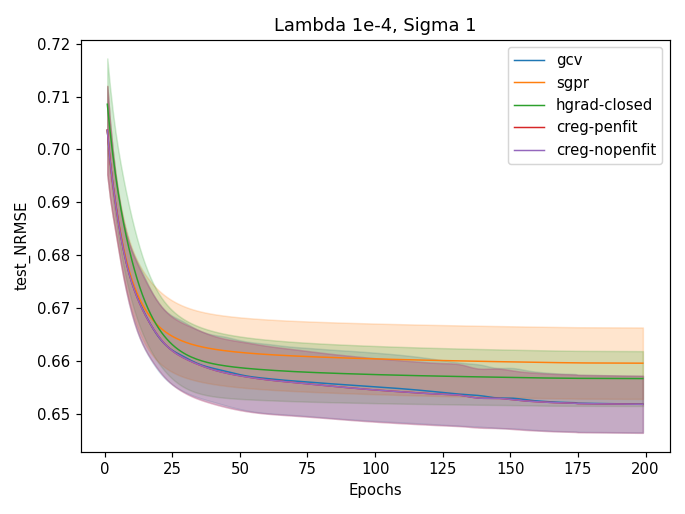

<IPython.core.display.Javascript object>


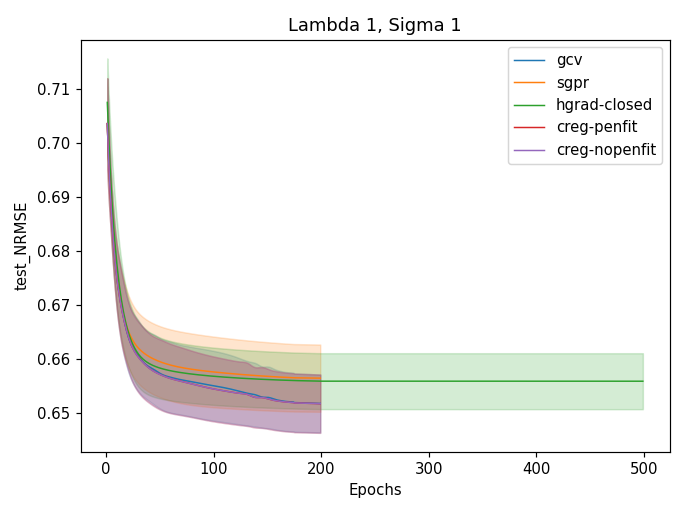

<IPython.core.display.Javascript object>


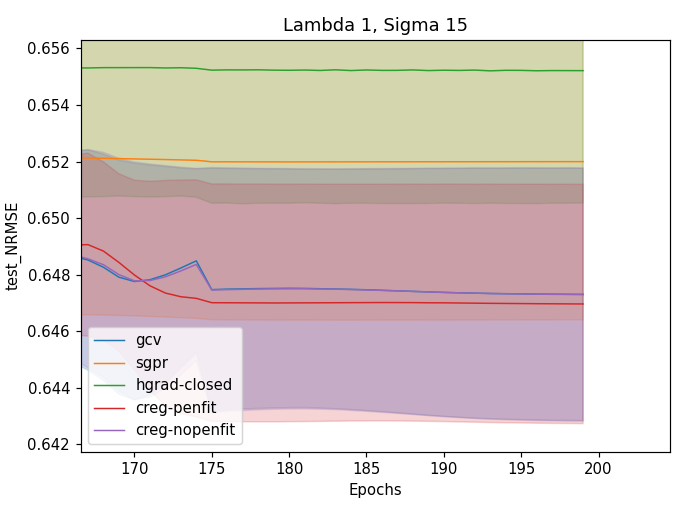

In [56]:
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit0.0001sinit15.0_meanrem_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 15")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit0.0001sinit1.0_meanrem_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_meanrem_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit15.0_meanrem_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 15")

<IPython.core.display.Javascript object>


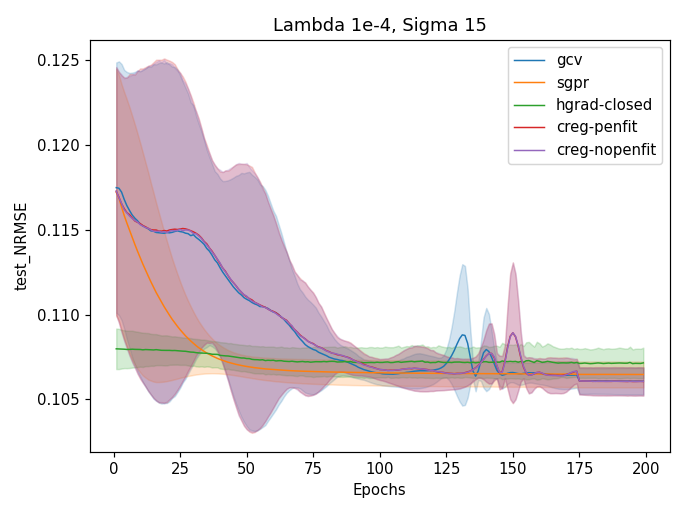

<IPython.core.display.Javascript object>


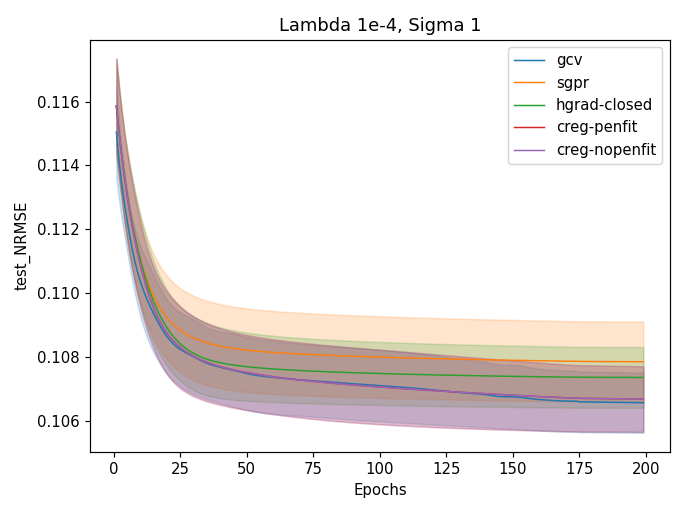

<IPython.core.display.Javascript object>


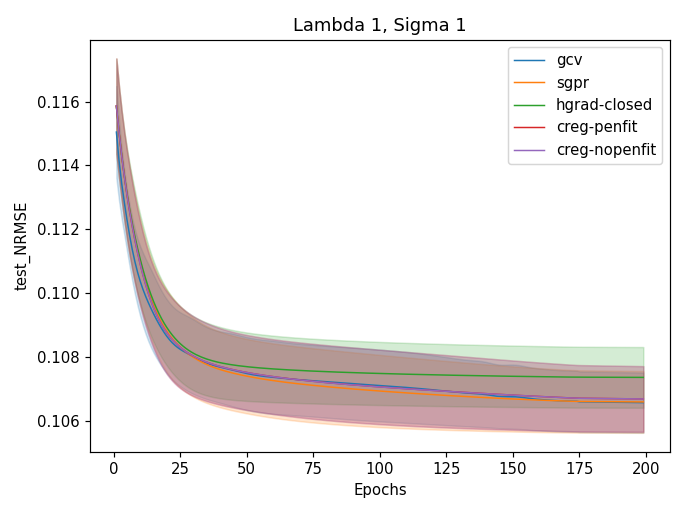

<IPython.core.display.Javascript object>


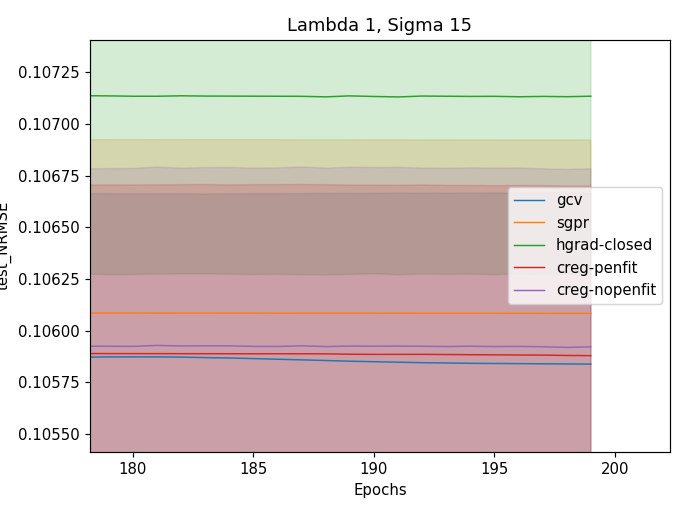

In [57]:
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit0.0001sinit15.0_stdy_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 15")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit0.0001sinit1.0_stdy_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit1.0_stdy_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.1_pinit1.0sinit15.0_stdy_val0.4_diagsig",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 15")

<IPython.core.display.Javascript object>


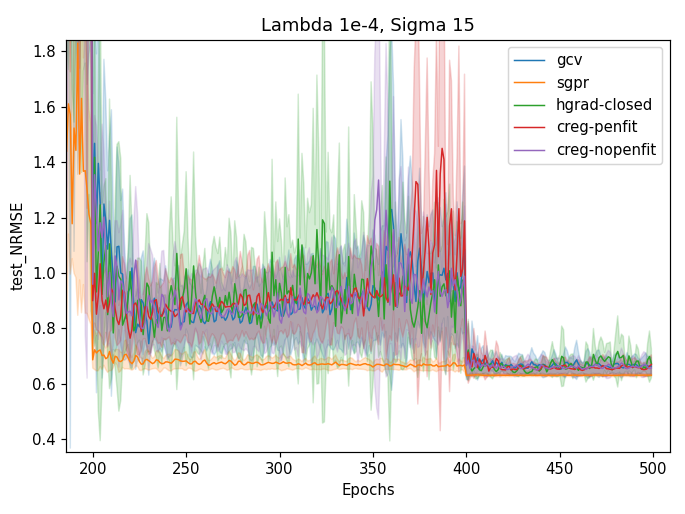

<IPython.core.display.Javascript object>


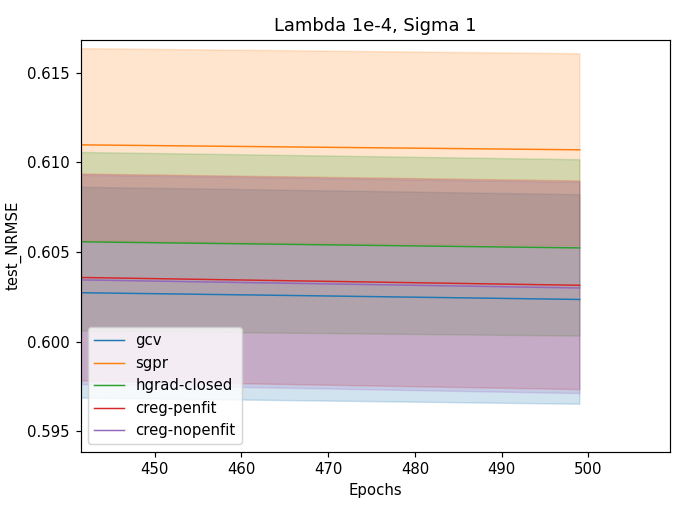

<IPython.core.display.Javascript object>


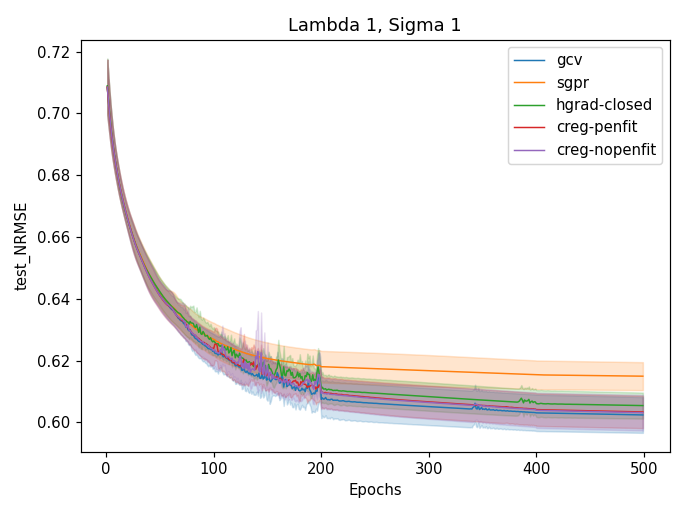

<IPython.core.display.Javascript object>


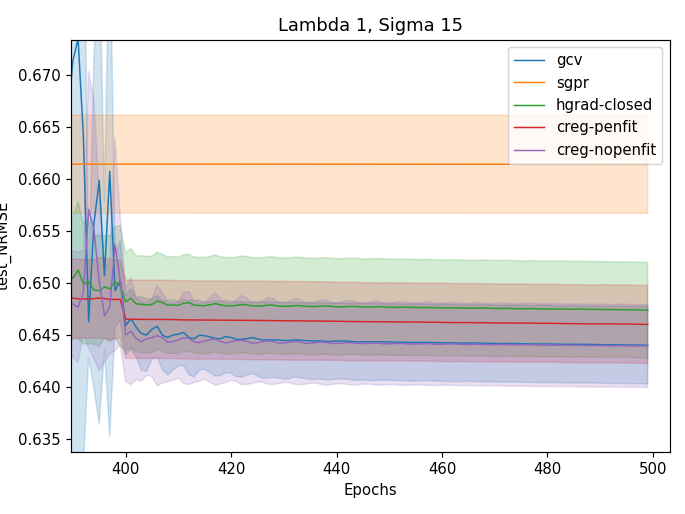

In [58]:
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.01_pinit0.0001sinit15.0_meanrem_val0.4_diagsig_optM",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 15")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.01_pinit0.0001sinit1.0_meanrem_val0.4_diagsig_optM",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1e-4, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.01_pinit1.0sinit1.0_meanrem_val0.4_diagsig_optM",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 1")
plot_single_error_traj(
    "test_hopt_adam_m20_lr0.01_pinit1.0sinit15.0_meanrem_val0.4_diagsig_optM",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 15")

<IPython.core.display.Javascript object>


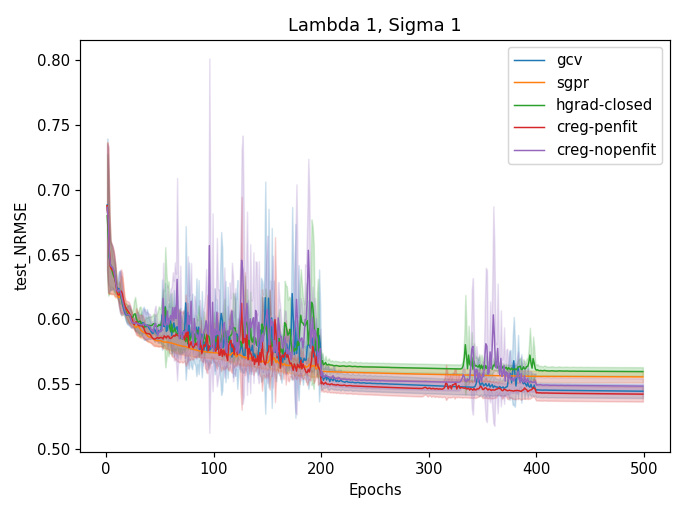

<ipython-input-54-46378aa4a08f>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


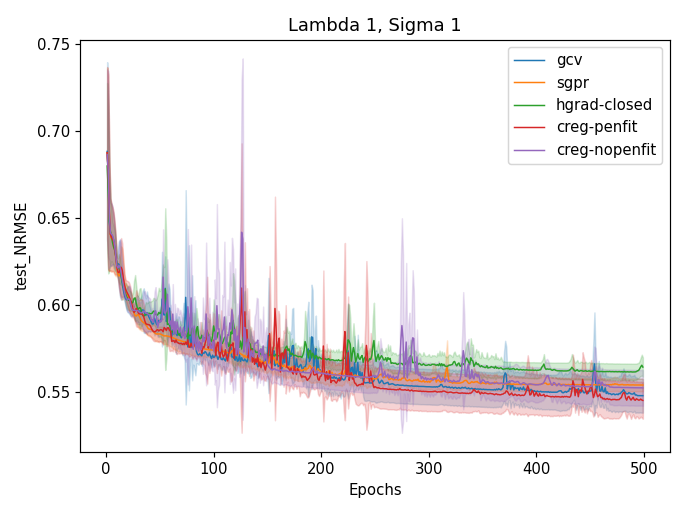

In [62]:
# This used StepLR(step_size=200, gamma=0.3) for 500 epochs
plot_single_error_traj(
    "test_hopt_adam_m100_lr0.01_pinit1.0sinit1.0_meanrem_val0.4_diagsig_optM",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 1")
# This used RecuceLROnPlateau(factor=0.3, patience=20) for 500 epochs with train_NRMSE
plot_single_error_traj(
    "test_hopt_adam_m100_lr0.01_pinit1.0sinit1.0_meanrem_val0.4_diagsig_optM_sec",
    "protein",
    ("gcv", "sgpr", "hgrad-closed", "creg-penfit", "creg-nopenfit"),
    extract_ts=None, title="Lambda 1, Sigma 1")
# Final results are pretty much the same, independently of the learning-rate schedule.

### A random test

In [3]:
import falkon
from falkon.kernels import GaussianKernel
from falkon.kernels.diff_rbf_kernel import DiffGaussianKernel
from falkon import FalkonOptions
from functools import partial
import scipy.linalg


[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


/home/giacomo/Dropbox/unige/falkon/falkon/falkon/utils/switches.py:21: UserWarning: Failed to initialize CUDA library; falling back to CPU. Set 'use_cpu' to True to avoid this warning.
  warnings.warn(get_error_str("CUDA", None))


In [4]:
kernel = GaussianKernel(2.0, opt=FalkonOptions(keops_active="no"))
def tri_inverse(T, lower):
    if T.dtype == torch.float32:
        Tinv = scipy.linalg.lapack.strtri(T.cpu().detach().numpy(), lower=lower, unitdiag=0, overwrite_c=0)
    elif T.dtype == torch.float64:
        Tinv = scipy.linalg.lapack.dtrtri(T.cpu().detach().numpy(), lower=lower, unitdiag=0, overwrite_c=0)
    else:
        raise TypeError("Dtype %s invalid" % (T.dtype))
    if Tinv[1] != 0:
        raise RuntimeError("TrTri failed ", Tinv[1])
    return torch.from_numpy(Tinv[0]).to(device=T.device)

In [21]:
@torch.jit.script
def squared_euclidean_distance(x1, x2):
    x1_norm = torch.norm(x1, p=2, dim=-1, keepdim=True).pow(2)
    x2_norm = torch.norm(x2, p=2, dim=-1, keepdim=True).pow(2)
    res = torch.addmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    res = res.clamp_min_(1e-30)
    return res

@torch.jit.script
def full_rbf_kernel(X1, X2, sigma):
    pairwise_dists = squared_euclidean_distance(X1 / sigma, X2 / sigma)
    return torch.exp(-0.5 * pairwise_dists)

class NystromKernelTrace(torch.autograd.Function):
    @staticmethod
    def tri_inverse(T, lower):
        if T.dtype == torch.float32:
            Tinv = scipy.linalg.lapack.strtri(T.cpu().detach().numpy(), lower=lower, unitdiag=0, overwrite_c=0)
        elif T.dtype == torch.float64:
            Tinv = scipy.linalg.lapack.dtrtri(T.cpu().detach().numpy(), lower=lower, unitdiag=0, overwrite_c=0)
        else:
            raise TypeError("Dtype %s invalid" % (T.dtype))
        if Tinv[1] != 0:
            raise RuntimeError("Trtri failed ", Tinv[1])
        return torch.from_numpy(Tinv[0]).to(device=T.device)

    @staticmethod
    def forward(ctx, kernel_args, M, X):
        diff_kernel = DiffGaussianKernel(
            kernel_args,
            opt=FalkonOptions(keops_active="no"))
        with torch.autograd.enable_grad():
            kmm = full_rbf_kernel(M, M, kernel_args)
            L = torch.cholesky(kmm)
        with torch.autograd.no_grad():
            Linv = tri_inverse(L, lower=1)
        with torch.autograd.enable_grad():
            k_linv = diff_kernel.mmv(X, M, Linv.T)
        
        ctx.save_for_backward(kernel_args, M)
        ctx.k_linv = k_linv
        ctx.L = L
        ctx.linv = Linv
        
        return k_linv.square().sum()
    
    @staticmethod
    def backward(ctx, out):
        kernel_args, M = ctx.saved_tensors

        with torch.autograd.no_grad():
            k_linv_linv = ctx.k_linv @ ctx.linv
        with torch.autograd.enable_grad():
            bg = out * (
                2 * (ctx.k_linv * ctx.k_linv.detach()).sum() - 
                2 * ( ctx.k_linv.detach() @ ctx.L.T * k_linv_linv ).sum()
            )

        needs_grad = []
        for i in range(2):
            if ctx.needs_input_grad[i]:
                needs_grad.append(ctx.saved_tensors[i])
        grads = torch.autograd.grad(bg, needs_grad, retain_graph=True)

        result = []
        j = 0
        for i in range(len(ctx.needs_input_grad)):
            if ctx.needs_input_grad[i]:
                result.append(grads[j])
                j += 1
            else:
                result.append(None)
        return tuple(result)
    

class NystromKernelTracev2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, kernel_args, M, X):
        diff_kernel = DiffGaussianKernel(
            kernel_args,
            opt=FalkonOptions(keops_active="no"))
        with torch.autograd.enable_grad():
            kmm = full_rbf_kernel(M, M, kernel_args)
            L = torch.cholesky(kmm)
        with torch.autograd.no_grad():
            Linv = tri_inverse(L, lower=1)
        with torch.autograd.enable_grad():
            kk_linv = diff_kernel.dmmv(X, M, Linv.T, None)  # M, M
        ctx.save_for_backward(kernel_args, M)
        ctx.kk_linv = kk_linv
        ctx.L = L
        ctx.linv = Linv
        
        return torch.trace(kk_linv @ Linv).sum()
    
    def backward(ctx, out):
        kernel_args, M = ctx.saved_tensors

        with torch.autograd.enable_grad():
            bg = out * (
                2 * torch.trace(ctx.kk_linv @ ctx.linv.detach())
                - torch.trace(ctx.kk_linv.detach() @ ctx.L.T @ ctx.linv.T @ ctx.linv)
                - torch.trace(ctx.kk_linv.detach() @ ctx.linv @ ctx.L @ ctx.linv)
            )
            
        needs_grad = []
        for i in range(2):
            if ctx.needs_input_grad[i]:
                needs_grad.append(ctx.saved_tensors[i])
        grads = torch.autograd.grad(bg, needs_grad, retain_graph=True)

        result = []
        j = 0
        for i in range(len(ctx.needs_input_grad)):
            if ctx.needs_input_grad[i]:
                result.append(grads[j])
                j += 1
            else:
                result.append(None)
        return tuple(result)

In [22]:
N = 10
D = 3
M = 6
torch.manual_seed(94)
X = torch.randn((N, D)).double()
XM = X[:M].clone().requires_grad_()
sigma = torch.tensor([10.0], requires_grad=True, dtype=X.dtype)
trace = NystromKernelTrace.apply(sigma, XM, X)
tracev2 = NystromKernelTracev2.apply(sigma, XM, X)
trace, tracev2

(tensor(9.9989, dtype=torch.float64, grad_fn=<NystromKernelTraceBackward>),
 tensor(9.9989, dtype=torch.float64, grad_fn=<NystromKernelTracev2Backward>))

In [23]:
trace.backward(retain_graph=True)
tracev2.backward(retain_graph=True)

In [24]:
def naive(kernel_args, M, X):
    diff_kernel = DiffGaussianKernel(
        kernel_args,
        opt=FalkonOptions(keops_active="no"))
    kmm = full_rbf_kernel(M, M, kernel_args)
    L = torch.linalg.cholesky(kmm)
    Linv = torch.linalg.inv(L)
    part1 = diff_kernel.mmv(X, M, Linv.T)
    return part1.square().sum()

In [25]:
trace = naive(sigma, XM, X)
trace

AttributeError: module 'torch.linalg' has no attribute 'cholesky'

In [26]:
trace.backward()

In [27]:
torch.autograd.gradcheck(
    lambda s, xm: NystromKernelTrace.apply(s, xm, X),
    (sigma, XM))#, eps=1e-4, atol=1e-4)

True

In [12]:
torch.autograd.gradcheck(
    lambda s, xm: NystromKernelTracev2.apply(s, xm, X),
    (sigma, XM))#, eps=1e-4, atol=1e-4)

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[0.0004]], dtype=torch.float64)
analytical:tensor([[-0.0035]], dtype=torch.float64)


In [395]:
kernel = GaussianKernel(sigma.detach(), opt=FalkonOptions(keops_active="no"))
kmm = kernel(XM, XM)
L = torch.linalg.cholesky(kmm)
real(X, XM, kernel, L)

tensor(9.9989, dtype=torch.float64)

In [28]:
"""
Trace(knm @ kmm^{-1} @ knm.T)

Often Kmm = L L^T so kmm^{-1} = L^{-T} L^{-1}
"""
def t1(X, M, kernel, L, T):
    """
    STE with bernoulli Z (n x t)
    solve L^{-1} (kmn @ Z)
    and then sum the entries
    """
    Z = torch.empty(X.shape[0], T, dtype=X.dtype, device=X.device).bernoulli_().mul_(2).sub_(1)
#     Z = torch.randn((X.shape[0], T))
    part1 = kernel.mmv(M, X, Z)
    part2 = torch.triangular_solve(part1, L, upper=False).solution
    return part2.square().sum(0).mean()

def t2(X, M, kernel, L, T):
    """
    STE with bernoulli Z (m x t)
    note Tr(knm @ Kmm^{-1} @ knm.T) = Tr(knm.T @ knm @ kmm^{-1}) = Tr(L^{-1} knm.T knm L^{-T}) so
    solve knm @ (L^{-1} @ Z)
    """
    Z = torch.empty(M.shape[0], T, dtype=X.dtype, device=X.device).bernoulli_().mul_(2).sub_(1)
#     Z = torch.randn((M.shape[0], T))
    part1 = torch.triangular_solve(Z, L, upper=False, transpose=True).solution.contiguous()
    part2 = kernel.mmv(X, M, part1)
    return part2.square().sum(0).mean()

def t3(X, M, kernel, L, T):
    """
    Using the same reordering as t2, but with direct inversion of L
    solve knm @ (L^{-1}).T
    """
    Linv = tri_inverse(L, lower=1)
    part1 = kernel.mmv(X, M, Linv.T)
    return part1.square().sum()

def t4(X, M, kernel, L, T):
    Z = torch.empty(M.shape[0], T, dtype=X.dtype, device=X.device).bernoulli_().mul_(2).sub_(1)
    part1 = torch.triangular_solve(Z, L, upper=False, transpose=True).solution.contiguous()
    kmm_p1 = kernel.mmv(M, M, part1)
    knm_p1 = kernel.mmv(X, M, part1)
    return M.shape[0] + knm_p1.square().sum(0).mean() - kmm_p1.square().sum(0).mean()

def real(X, M, kernel, L):
    kmm = kernel(M, M)
    knm = kernel(X, M)
    part1 = torch.triangular_solve(knm.T, L, upper=False).solution
    return part1.square().sum()

def calc_var(fn, real, reps=10):
    res = np.array([fn().item() for _ in range(reps)])
    err = res - real.item()
    return np.std(err)

In [29]:
N, M, D = int(1e5), int(50), 10
T = 20

In [30]:
X = torch.randn((N, D))
XM = X[:M].clone()

In [32]:
kmm = kernel(XM, XM)
L = torch.cholesky(kmm)

In [33]:
calc_var(partial(t1, X, XM, kernel, L, T), real(X, XM, kernel, L), 200)

4646.107026891455

In [34]:
calc_var(partial(t2, X, XM, kernel, L, T), real(X, XM, kernel, L), 200)

3854.357483992288

In [35]:
calc_var(partial(t3, X, XM, kernel, L, T), real(X, XM, kernel, L), 200)

0.0

In [36]:
calc_var(partial(t4, X, XM, kernel, L, T), real(X, XM, kernel, L), 200)

4140.29687533014

In [37]:
%%timeit
t1(X, XM, kernel, L, T)

53.8 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit
t2(X, XM, kernel, L, T)

52.5 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
t3(X, XM, kernel, L, T)

54.5 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%%timeit
t4(X, XM, kernel, L, T)

61.5 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [191]:
%%timeit
real(X, XM, kernel, L)

894 ms ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
# %%timeit
real(X, XM, kernel, L), t2(X, XM, kernel, L, T), t1(X, XM, kernel, L, T), t3(X, XM, kernel, L, T)

(tensor(40506.3203),
 tensor(40099.6992),
 tensor(40947.0039),
 tensor(40506.3203))